In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from scipy.interpolate import interp1d
import lmfit as lm
import scipy.cluster.hierarchy as ch

In [2]:
egfp=scipy.io.loadmat('egfp.mat')
egfp0=egfp['egfp'][0][0].T
egfp1=egfp['egfp'][0][1].T
egfp2=egfp['egfp'][0][2].T
egfp3=egfp['egfp'][0][3].T
egfp4=egfp['egfp'][0][4].T
egfp5=egfp['egfp'][0][5].T
print(egfp2.shape)
print(egfp3.shape)
egfp_lipo=np.vstack((egfp2,egfp3))
#print(egfp_lipo[0])

(165, 87)
(168, 87)


In [3]:
def twostage(t,t0,ktl,delta,beta):
    km=np.abs(ktl)
    delta=np.abs(delta)
    beta=np.abs(beta)
    t0=np.abs(t0)
    return (ktl/(delta-beta)*(1-np.exp(-(delta-beta)*(t-t0)))*np.exp(-beta*(t-t0))).clip(0)
twostage_model = lm.Model(twostage)

In [4]:
def threestage(t,t0,ktl,km,delta,beta):
    km=np.abs(km)
    ktl=np.abs(ktl)
    delta=np.abs(delta)
    beta=np.abs(beta)
    dmb = delta-beta
    bkm = beta + km
    dmbk = delta-bkm
    t0=np.abs(t0)
    dt=t-t0
    result = 1/dmb +km*np.exp(-dmb*dt)/dmb/dmbk-np.exp(-km*dt)/dmbk
    result = ktl*np.exp(-beta*dt)*result.clip(0)
    result[t<t0]=0
    return result
threestage_model = lm.Model(threestage)

[[Model]]
    Model(twostage)
[[Fit Statistics]]
    # function evals   = 84
    # data points      = 87
    # variables        = 4
    chi-square         = 2717.947
    reduced chi-square = 32.746
    Akaike info crit   = 311.525
    Bayesian info crit = 321.388
[[Variables]]
    t0:      1.79228068 +/- 0.042970 (2.40%) (init= 7)
    ktl:     1218.72894 +/- 38.40963 (3.15%) (init= 800)
    delta:   0.04486945 +/- 1.869844 (4167.30%) (init= 0.07)
    beta:   -0.04489656 +/- 1.870208 (4165.59%) (init= 0.05)
[[Correlations]] (unreported correlations are <  0.100)
    C(delta, beta)               =  1.000 
    C(t0, ktl)                   =  0.623 

[[Model]]
    Model(threestage)
[[Fit Statistics]]
    # function evals   = 8827
    # data points      = 87
    # variables        = 5
    chi-square         = 1403.045
    reduced chi-square = 17.110
    Akaike info crit   = 257.052
    Bayesian info crit = 269.382
[[Variables]]
    t0:     -0.88419227 +/- 0.071743 (8.11%) (init= 7)
    ktl:

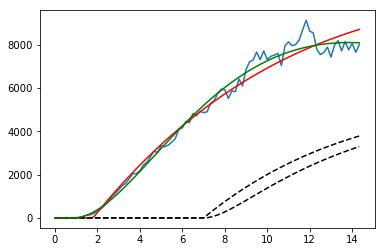

In [5]:
data = egfp_lipo[0]
sigma = np.sqrt(data)
time = np.arange(0,data.size)*10/60
result2 = twostage_model.fit(data, t=time, t0=7, ktl=800, delta=0.07, beta=0.05, weights=1/sigma)
result3 = threestage_model.fit(data, t=time, t0=7, ktl=800, km=1,delta=0.07, beta=0.05, weights=1/sigma)
plt.figure()
plt.plot(time,data)
plt.plot(time,result2.init_fit, 'k--')
plt.plot(time, result2.best_fit, 'r-')
plt.plot(time,result3.init_fit, 'k--')
plt.plot(time, result3.best_fit, 'g-')
plt.ylim((-0.05*data.max(),data.max()*1.05))
print(result2.fit_report())
print(result3.fit_report())

In [6]:
# cluster analysis to find the onset for fluorescence
# normalize the data
time_norm=(time-time.min())/50/(time.max()-time.min())
t0cluster_list=[]
for data in egfp_lipo:
    data_norm=(data-data.min())/(data.max()-data.min())
    data_diff_norm=np.gradient(data_norm)
    # combine the data
    X = np.vstack((time_norm,data_norm,data_diff_norm)).T
    # generate the linkage matrix
    Z = ch.linkage(X, method='single',metric='cityblock')
    tree = ch.cut_tree(Z, height=0.003).flatten()
    t0cluster_list.append(tree[tree==0].size)
t0cluster_list=np.array(t0cluster_list)
# convert to hours
t0cluster_list=(t0cluster_list)*10/60

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


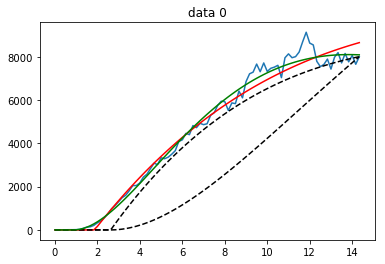

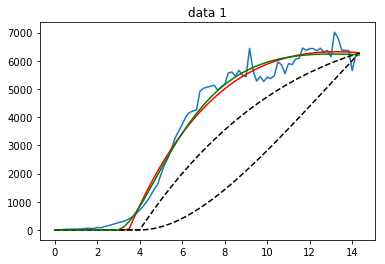

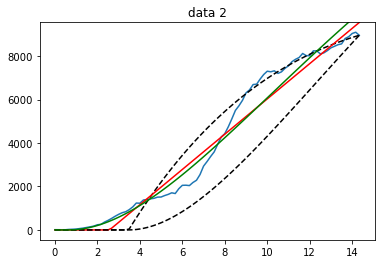

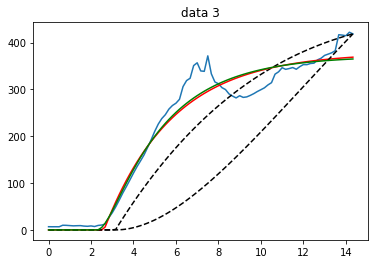

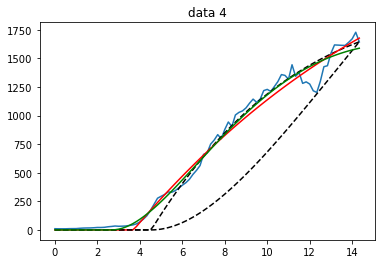

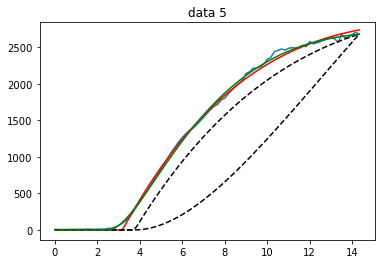

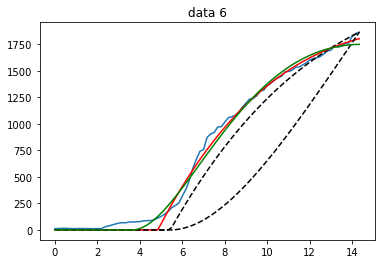

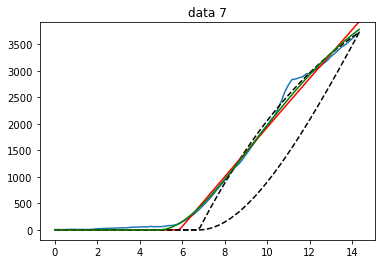

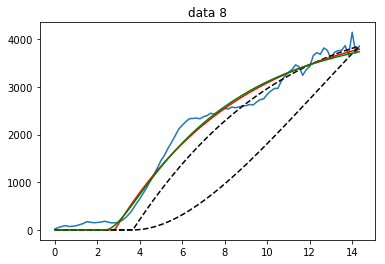

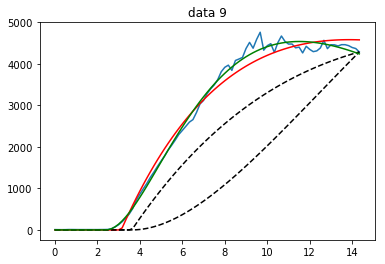

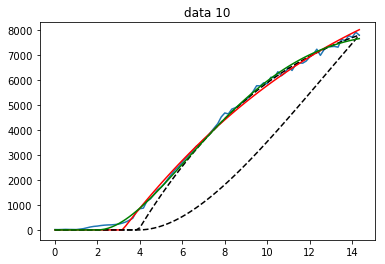

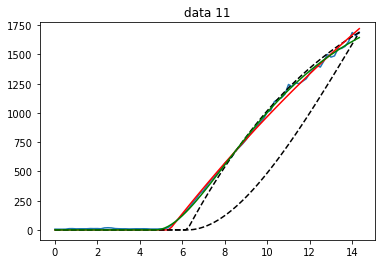

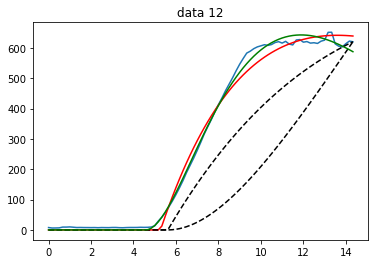

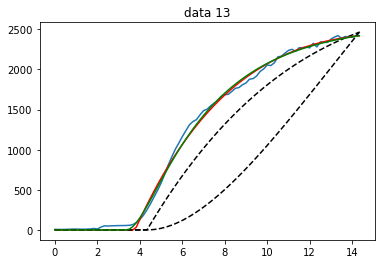

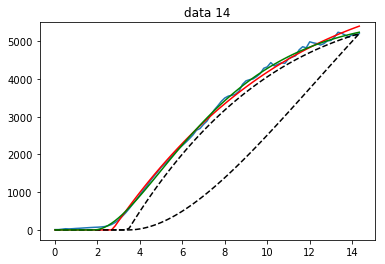

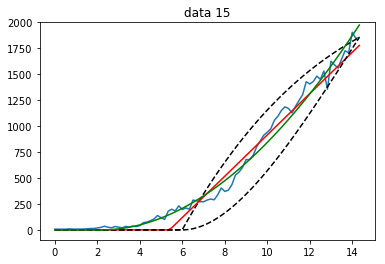

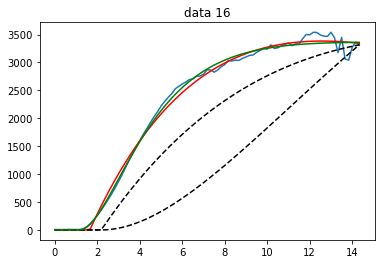

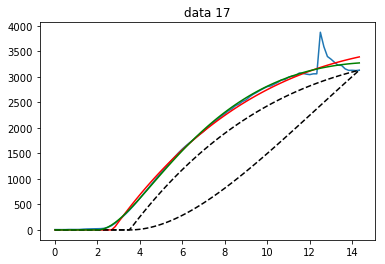

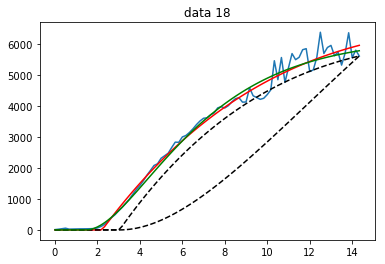

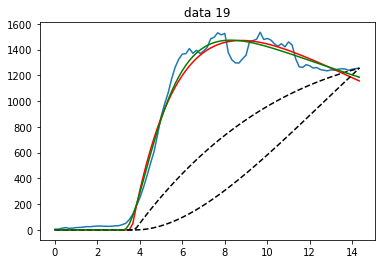

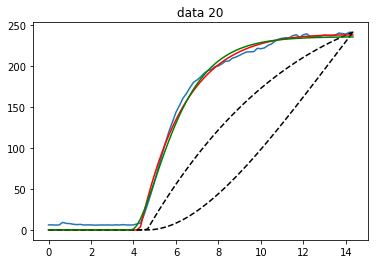

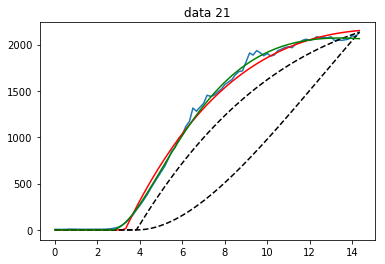

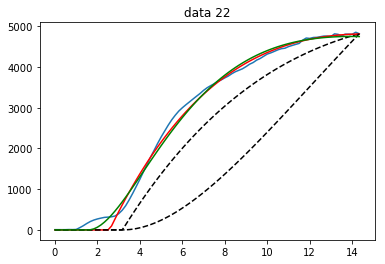

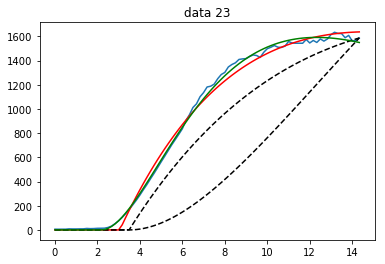

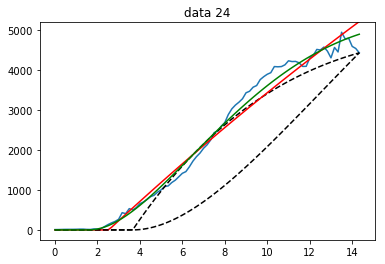

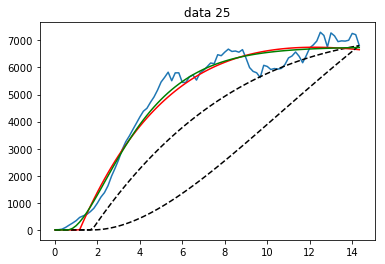

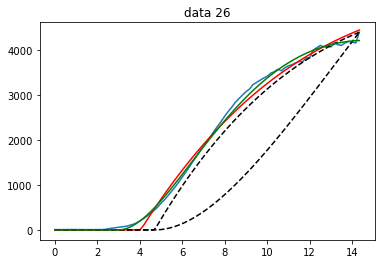

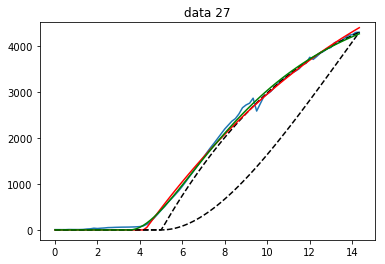

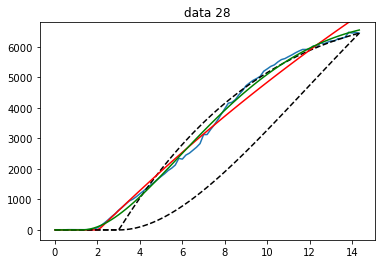

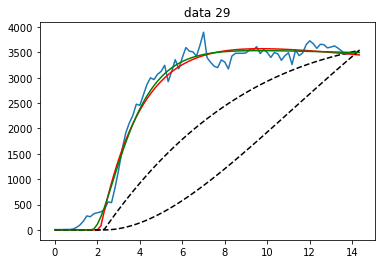

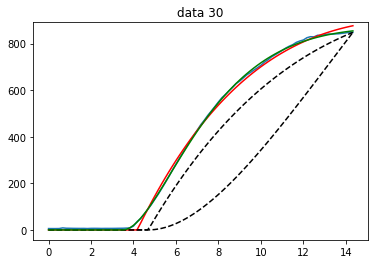

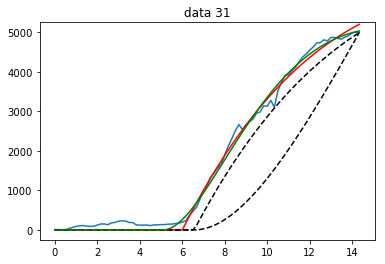

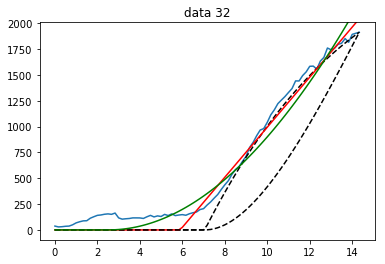

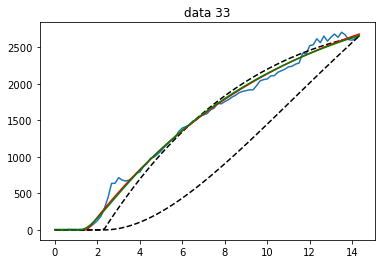

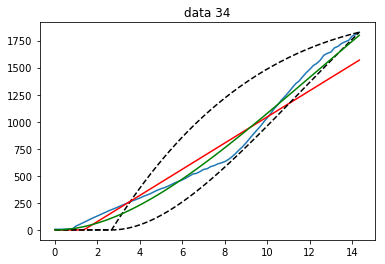

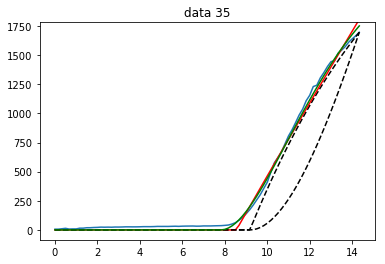

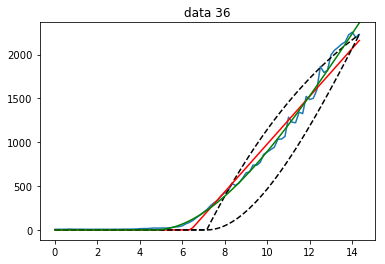

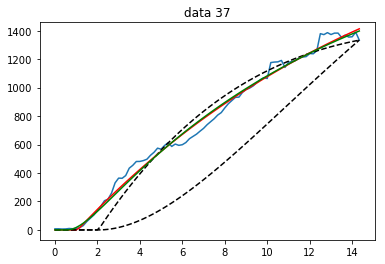

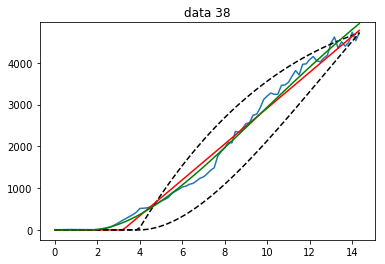

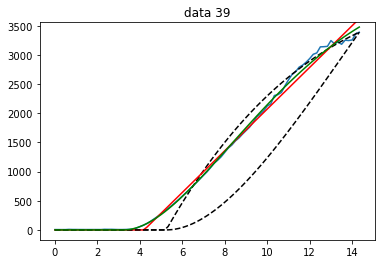

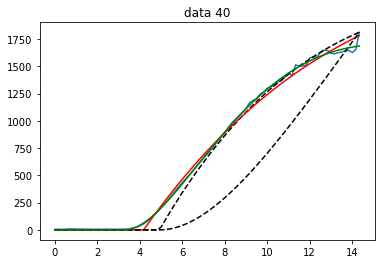

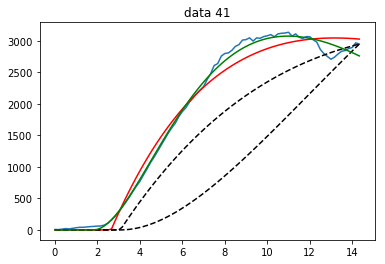

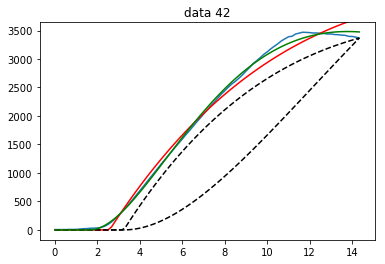

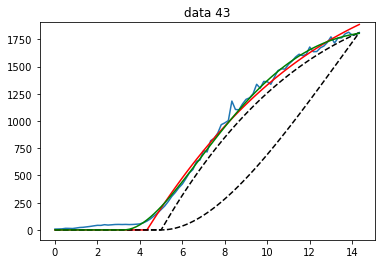

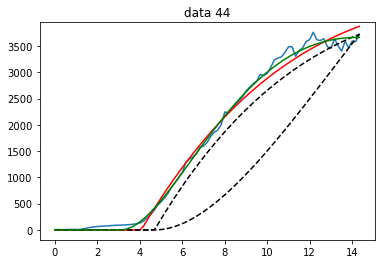

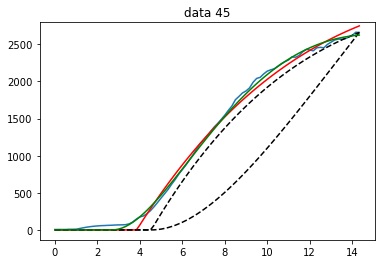

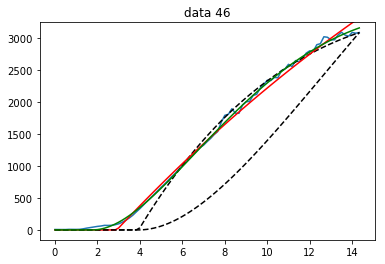

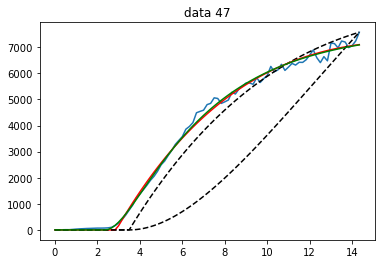

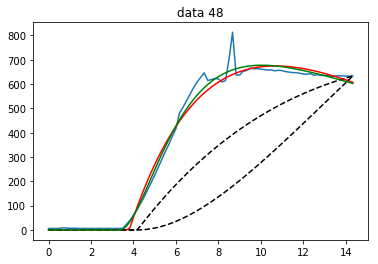

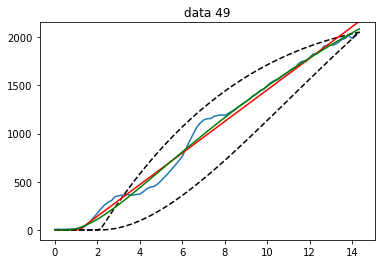

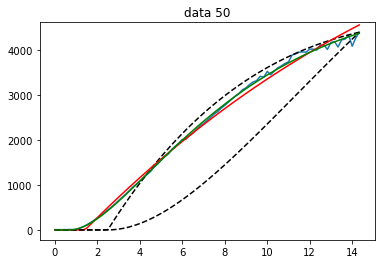

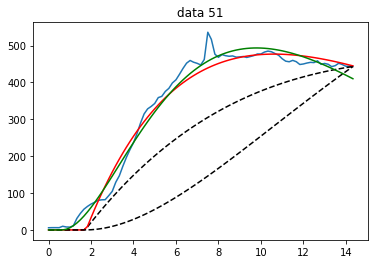

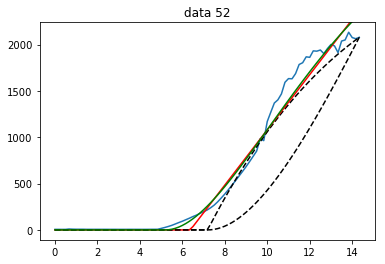

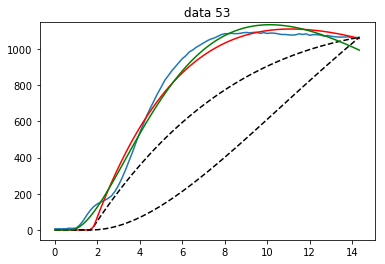

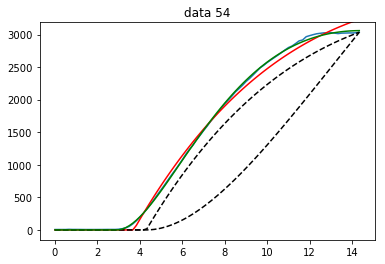

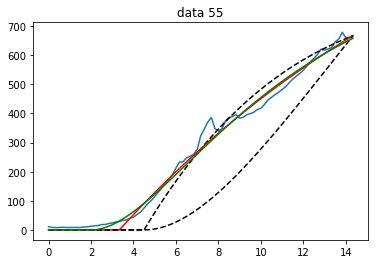

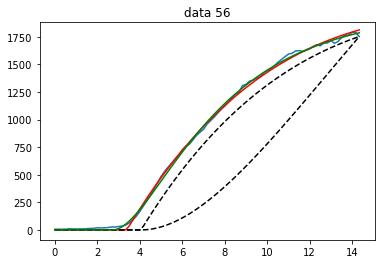

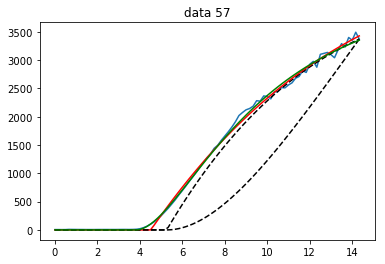

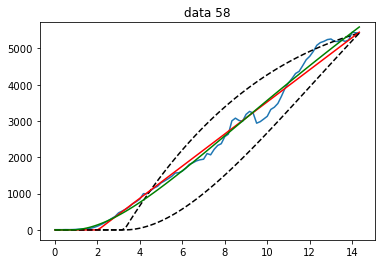

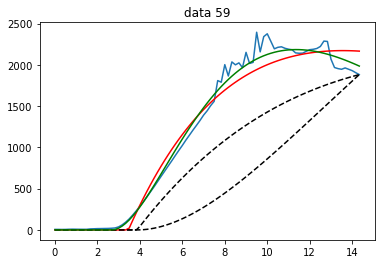

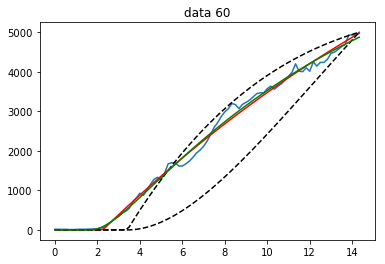

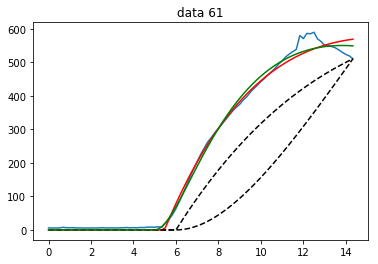

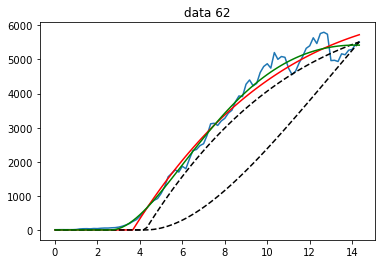

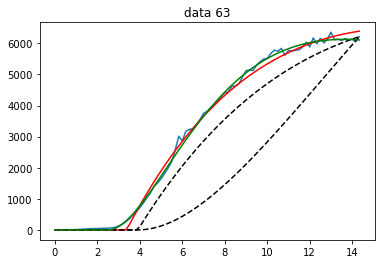

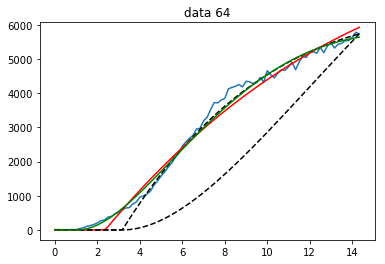

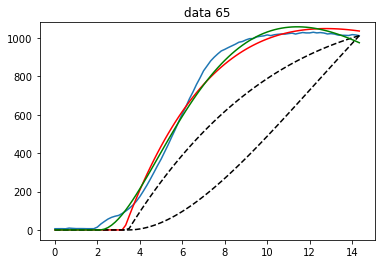

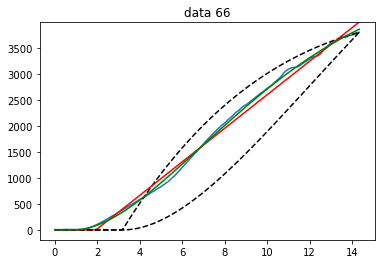

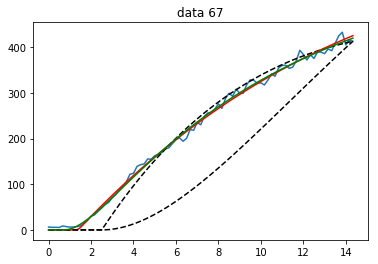

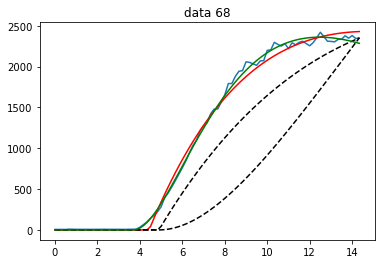

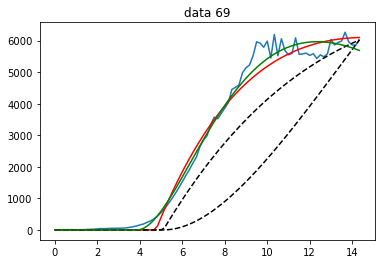

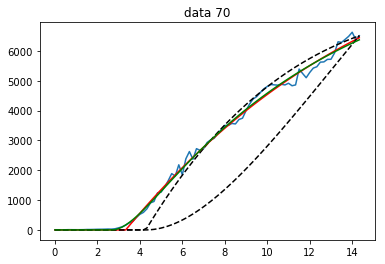

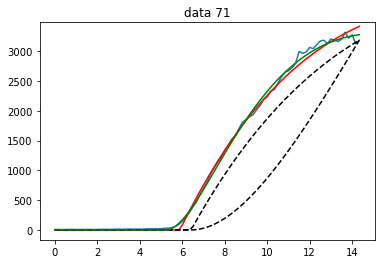

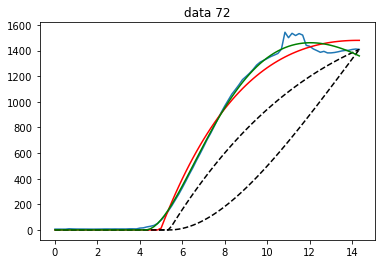

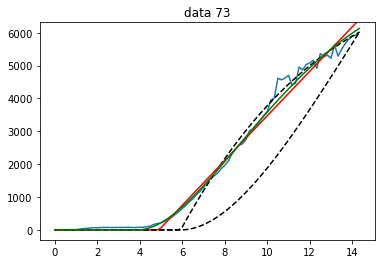

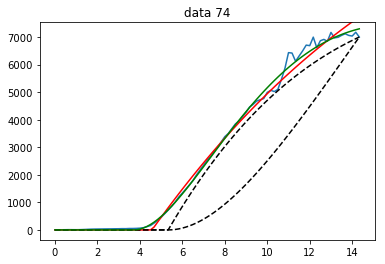

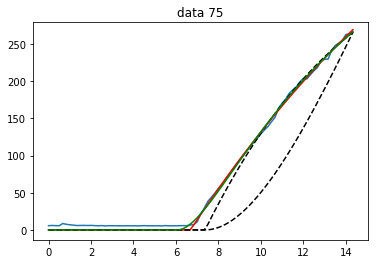

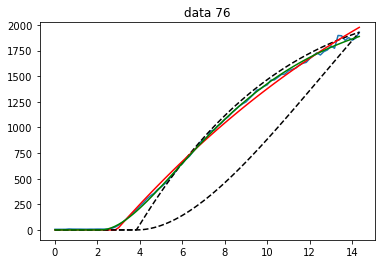

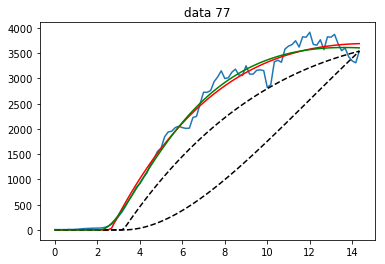

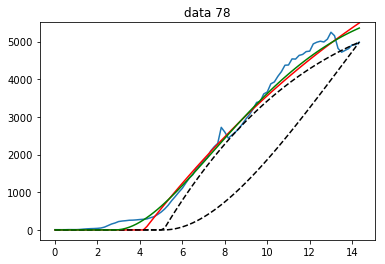

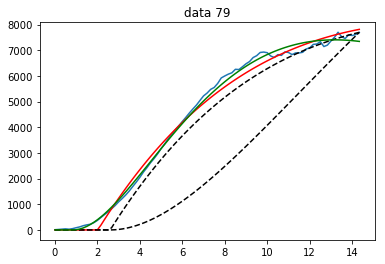

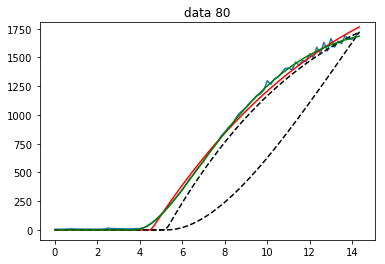

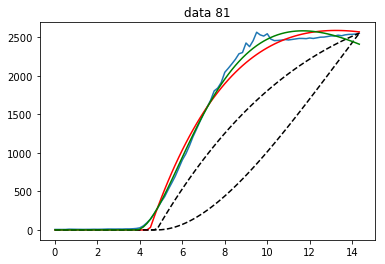

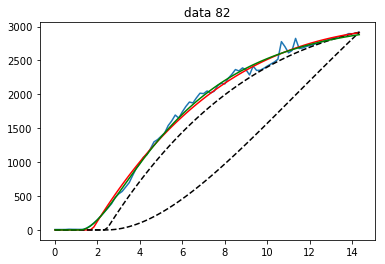

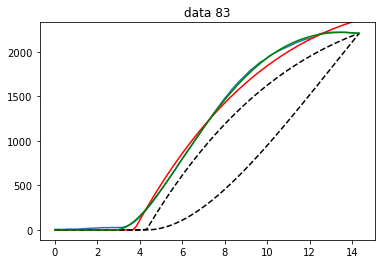

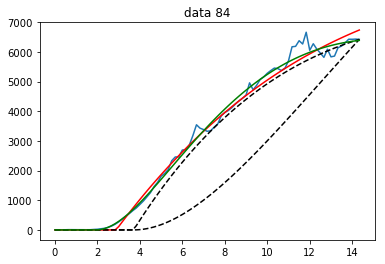

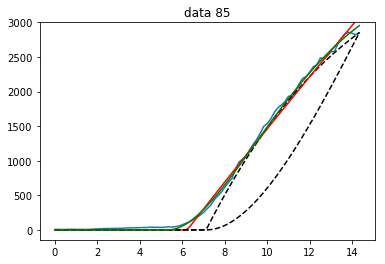

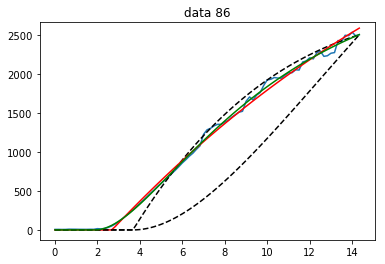

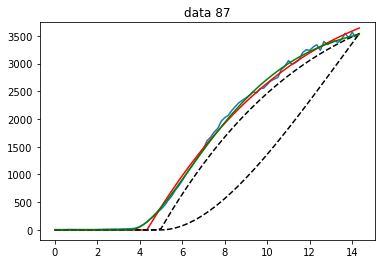

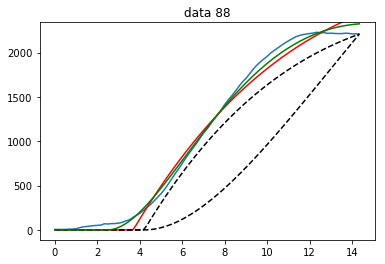

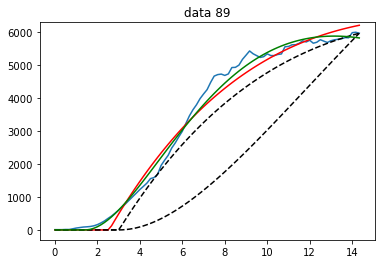

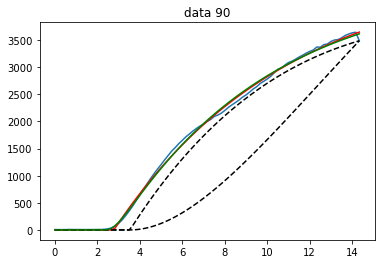

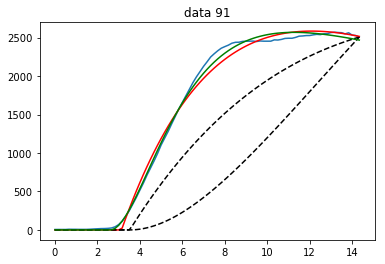

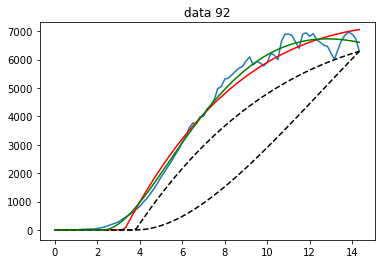

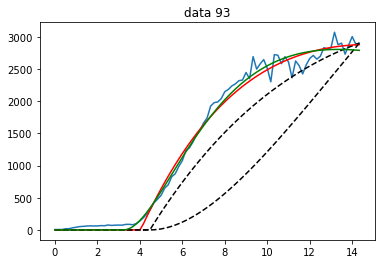

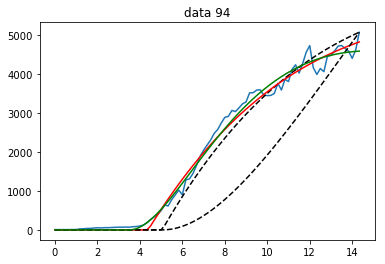

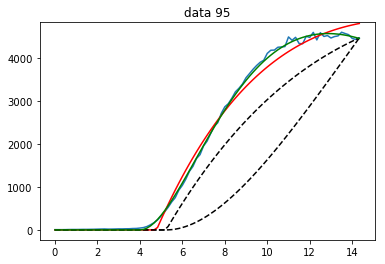

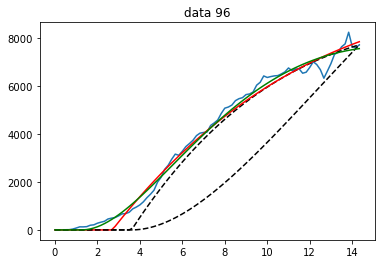

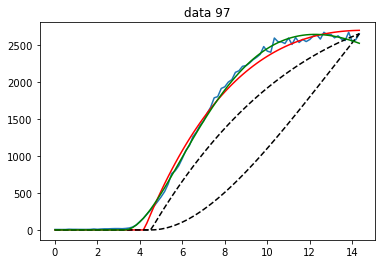

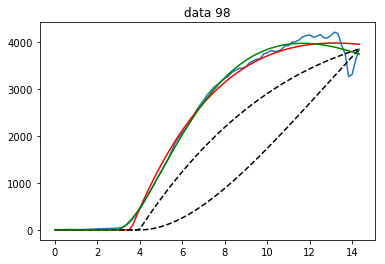

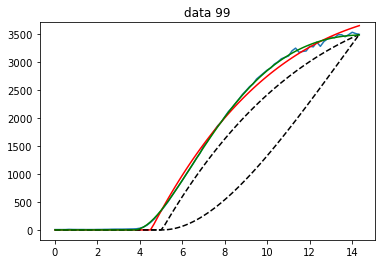

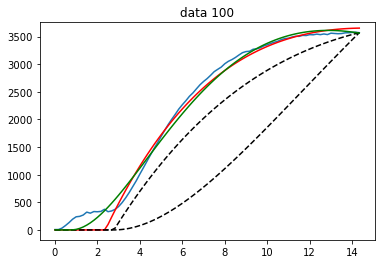

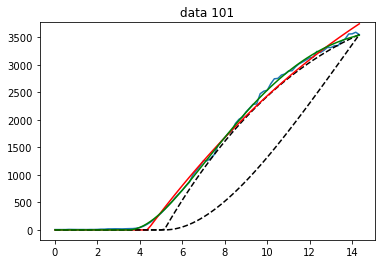

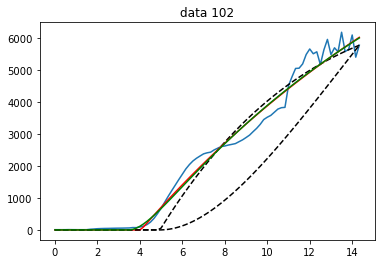

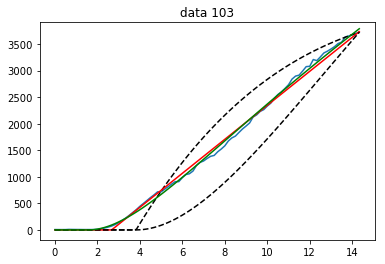

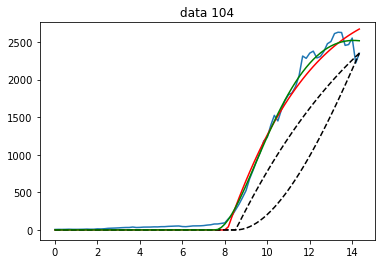

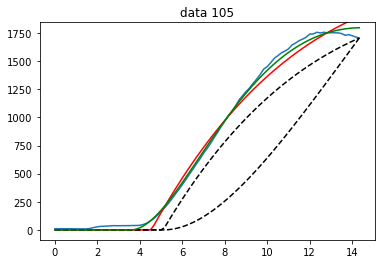

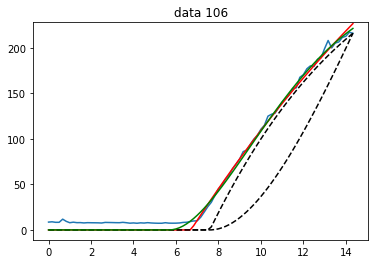

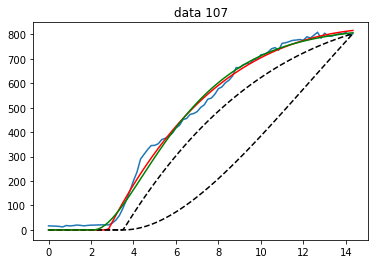

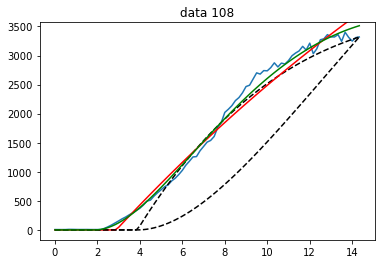

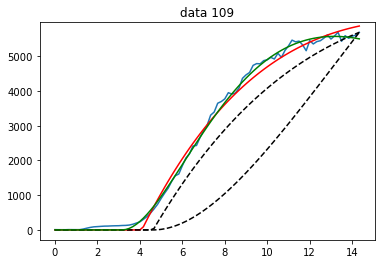

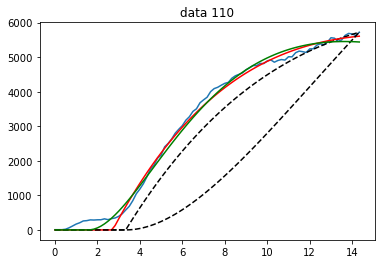

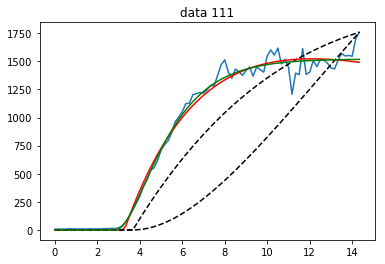

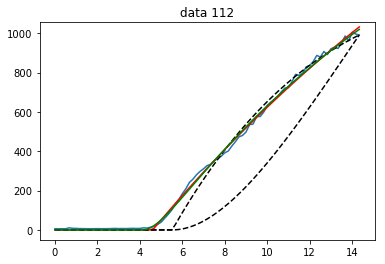

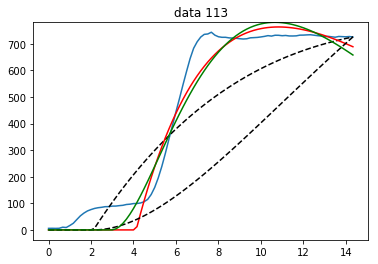

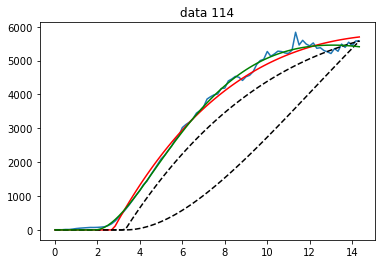

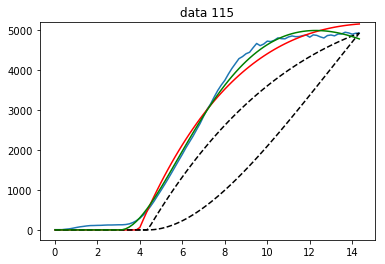

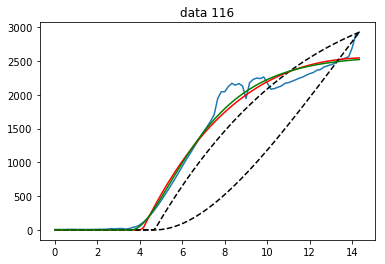

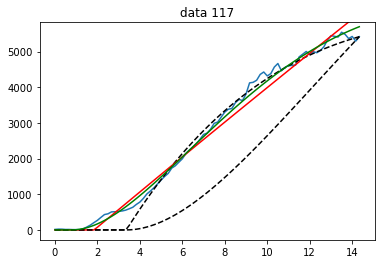

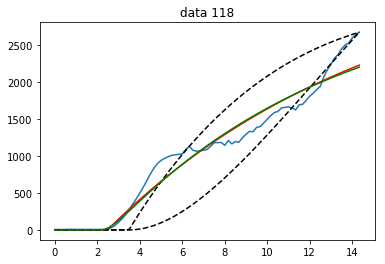

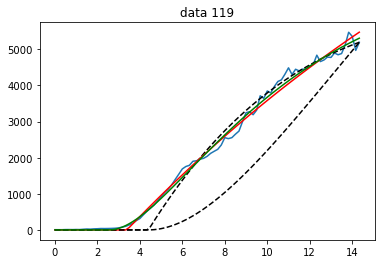

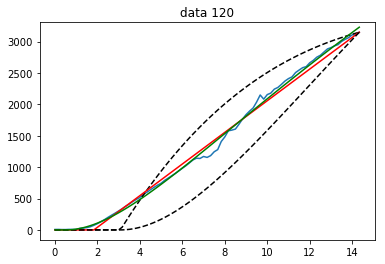

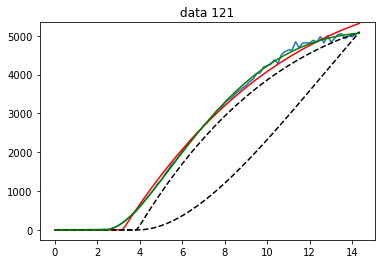

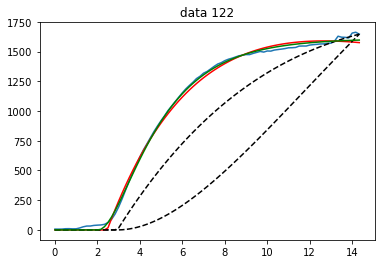

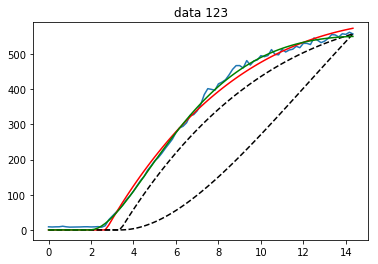

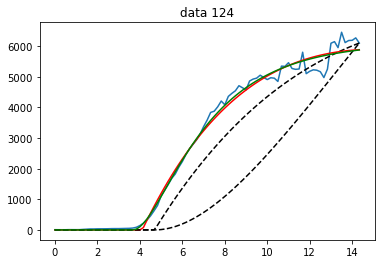

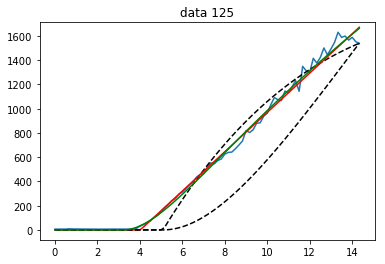

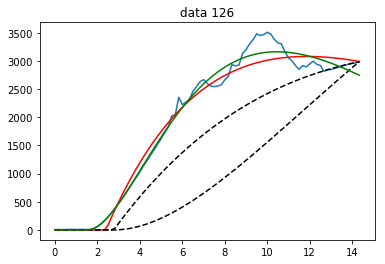

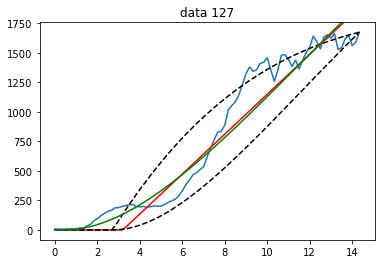

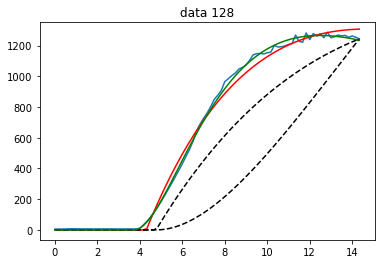

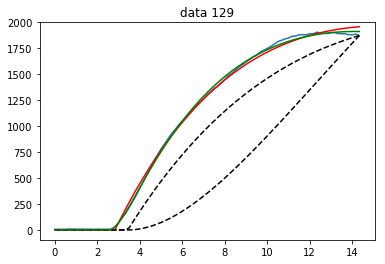

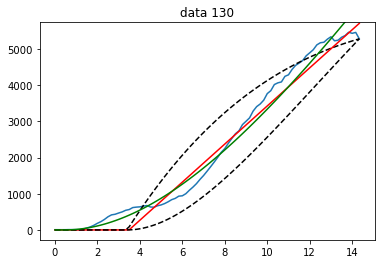

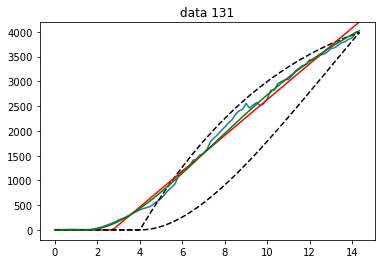

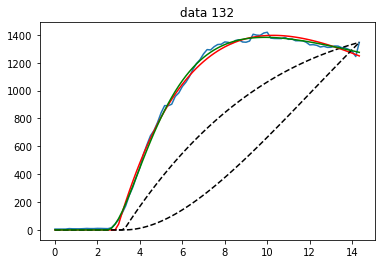

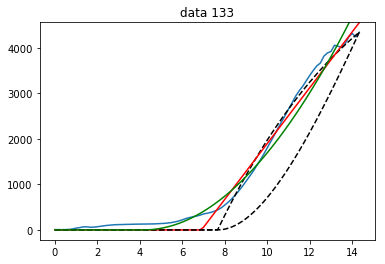

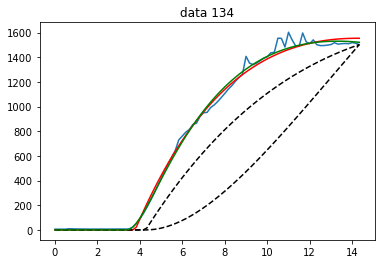

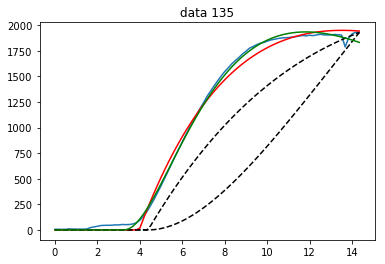

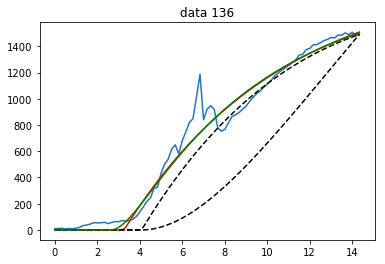

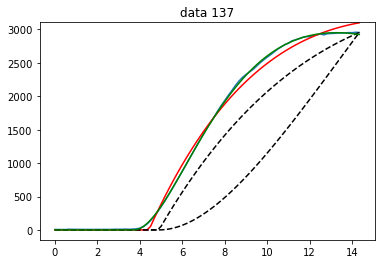

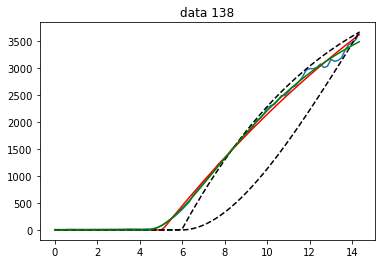

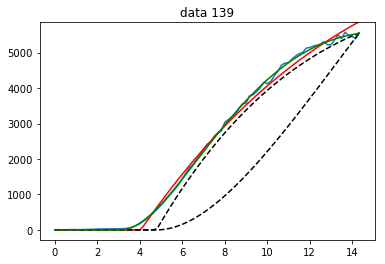

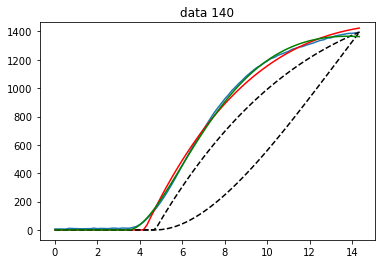

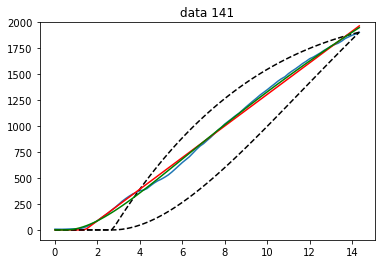

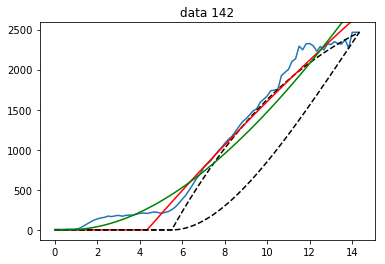

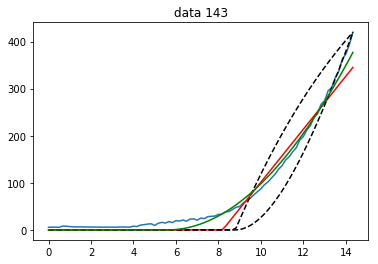

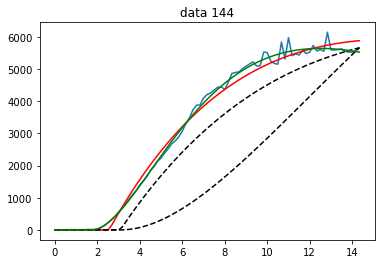

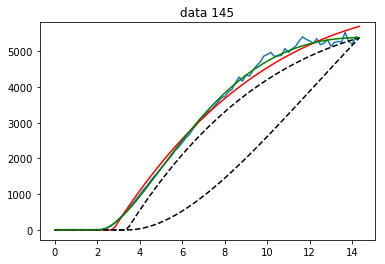

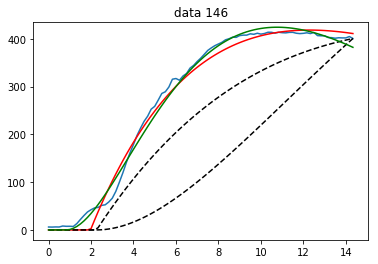

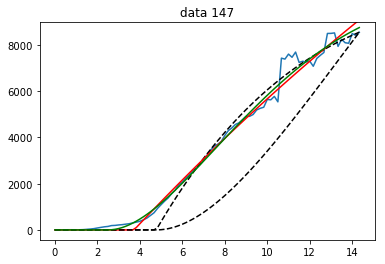

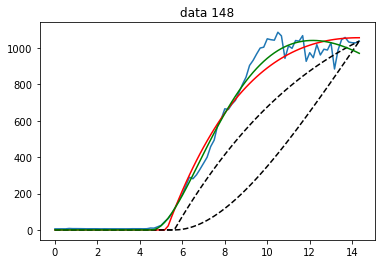

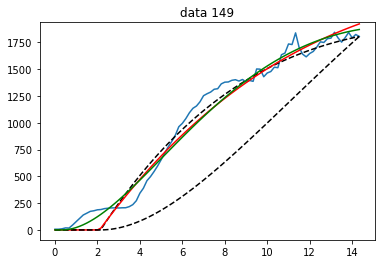

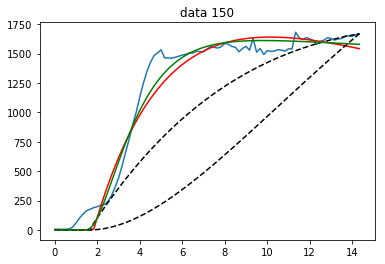

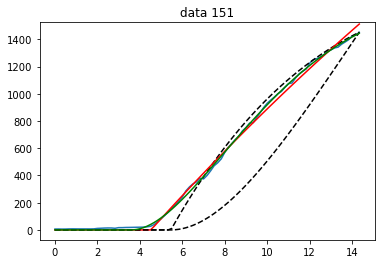

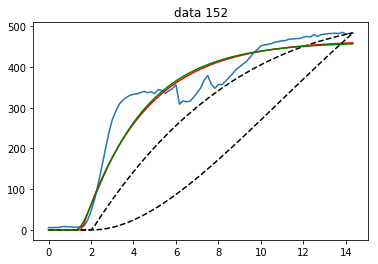

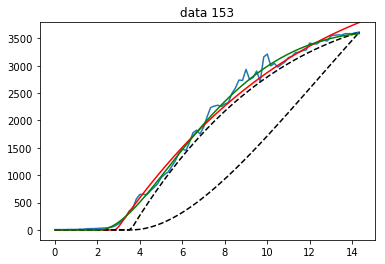

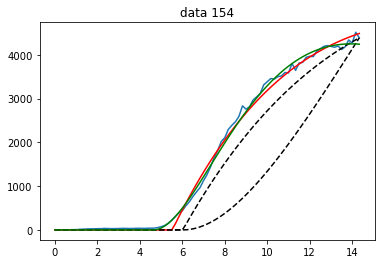

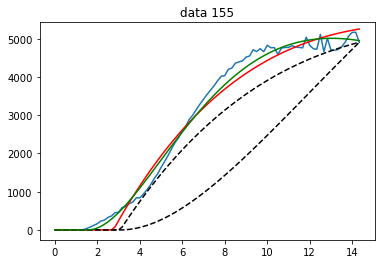

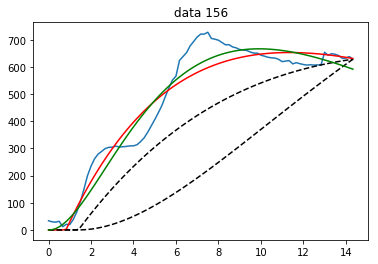

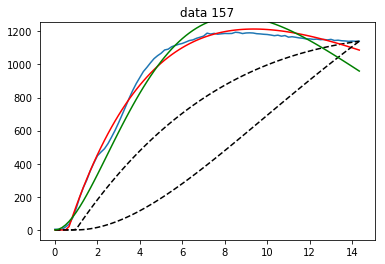

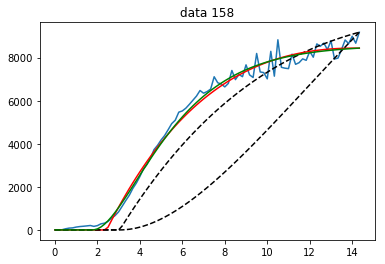

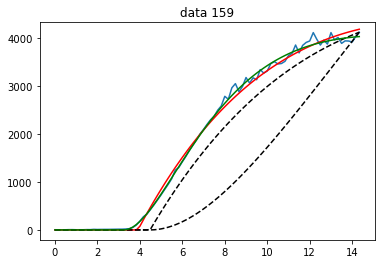

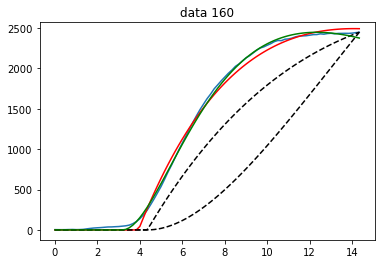

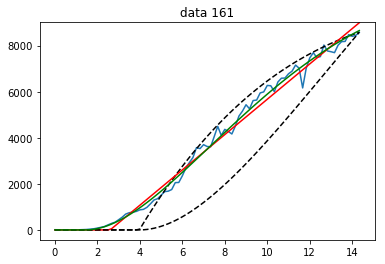

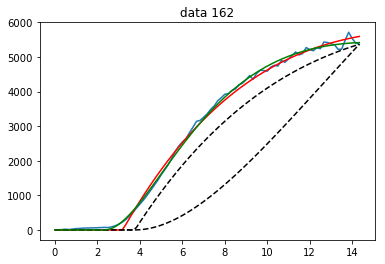

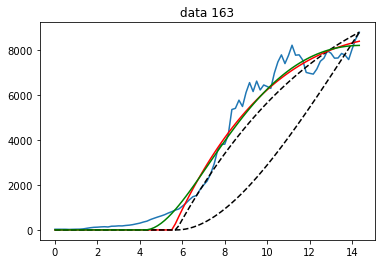

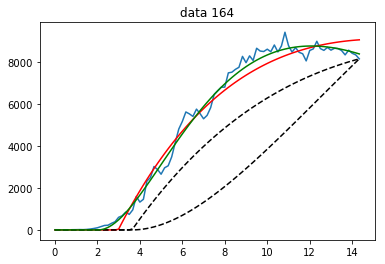

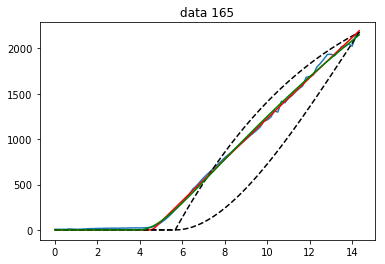

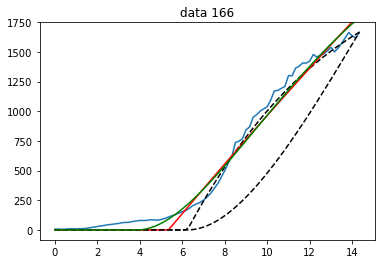

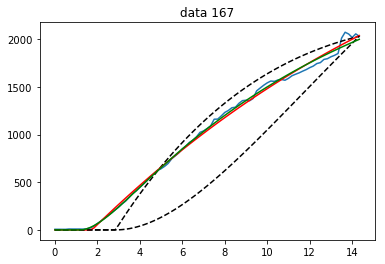

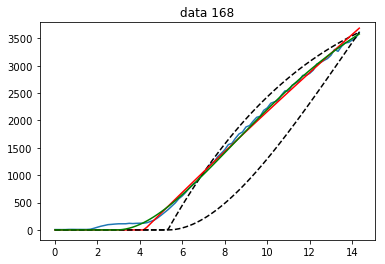

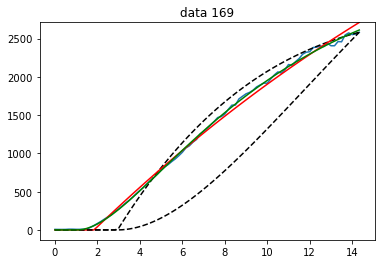

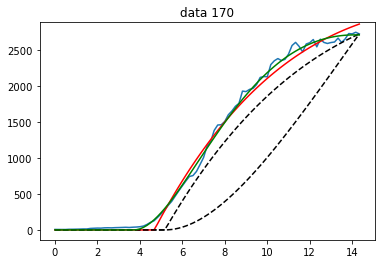

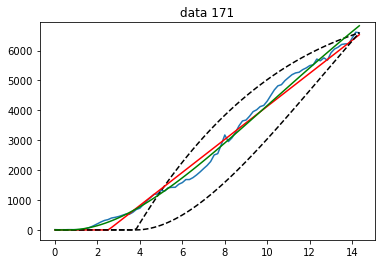

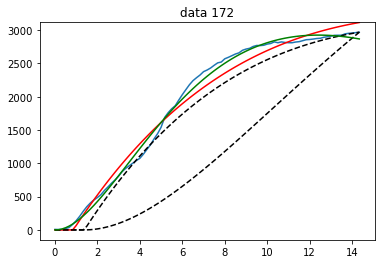

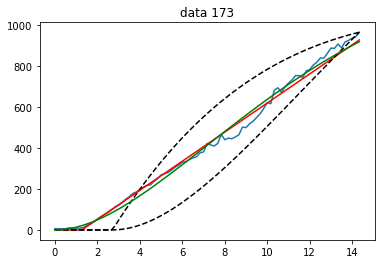

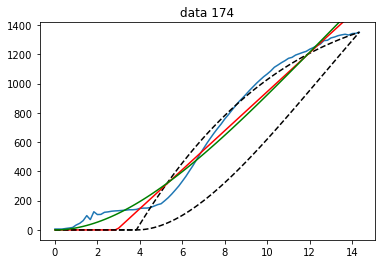

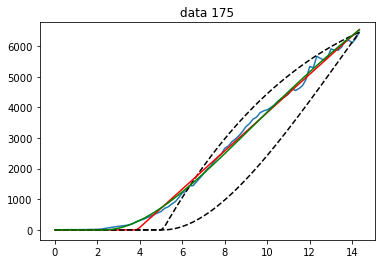

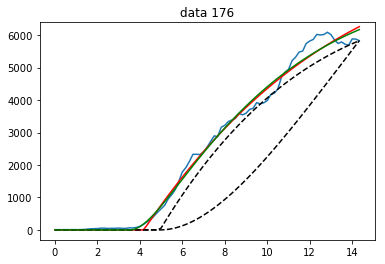

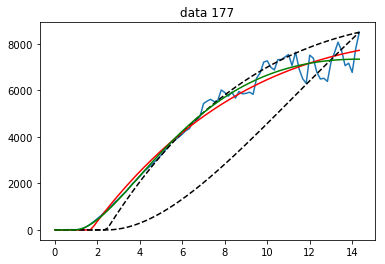

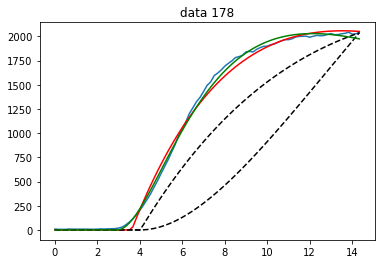

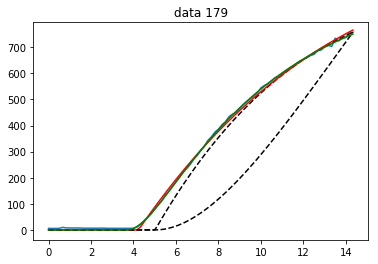

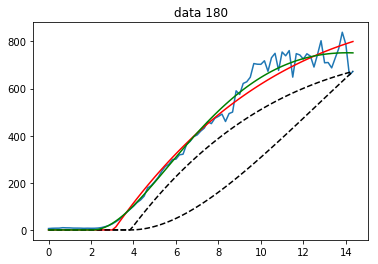

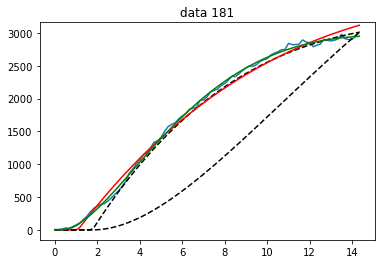

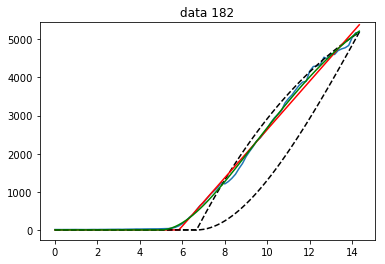

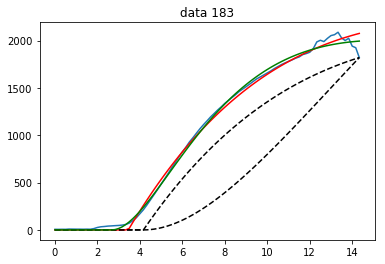

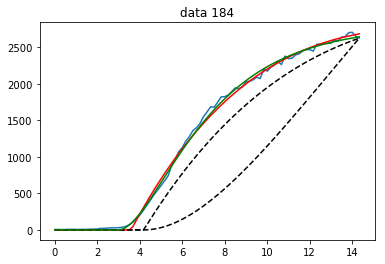

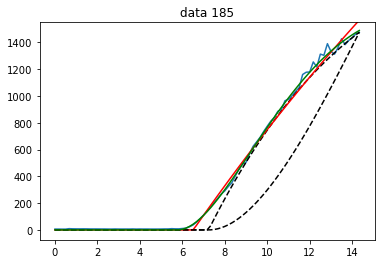

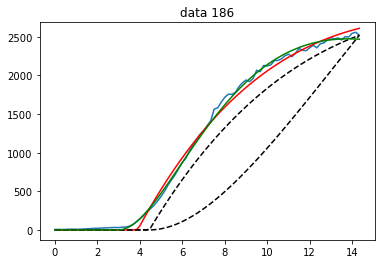

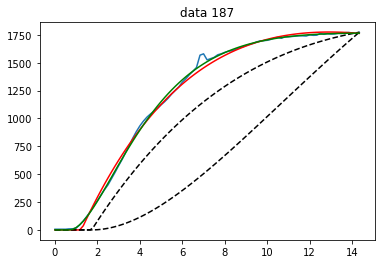

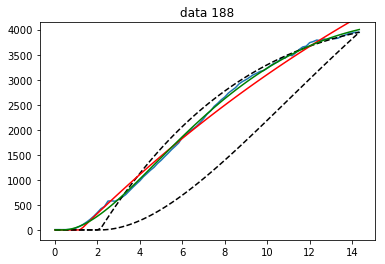

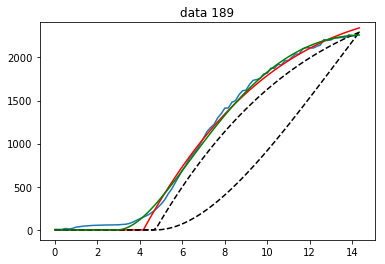

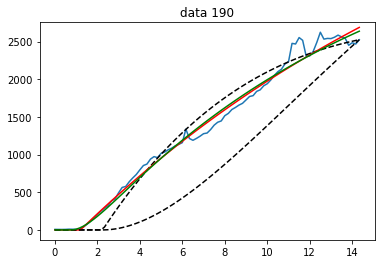

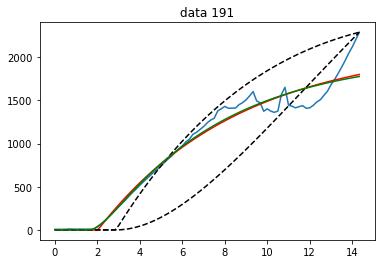

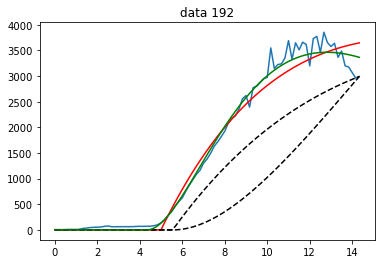

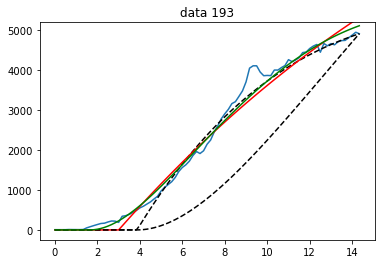

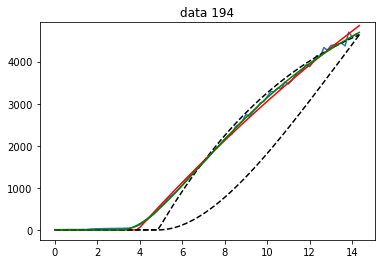

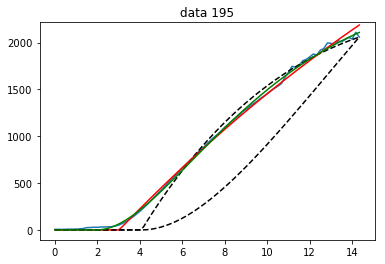

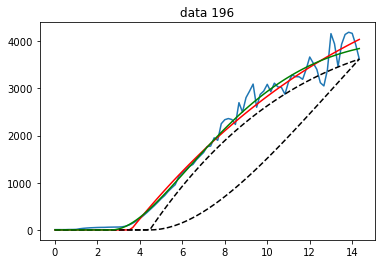

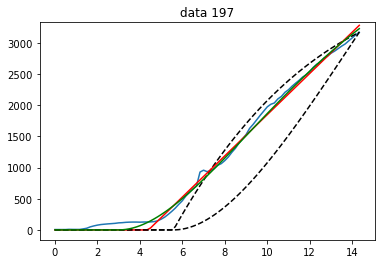

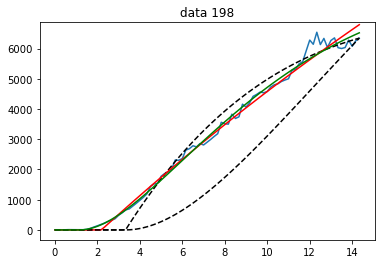

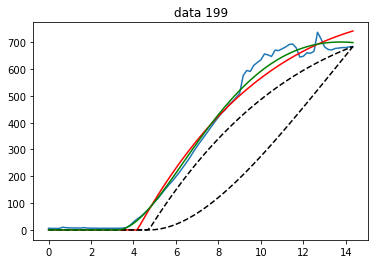

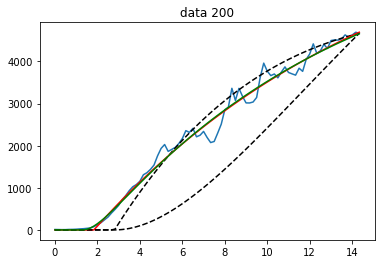

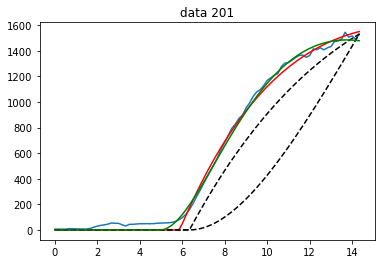

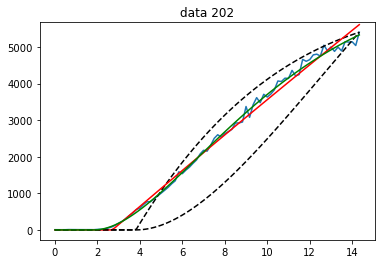

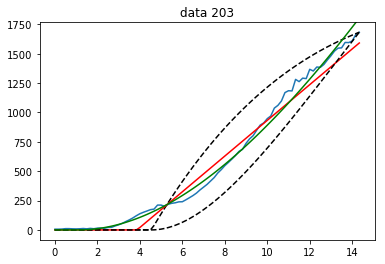

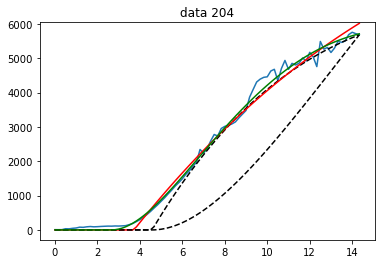

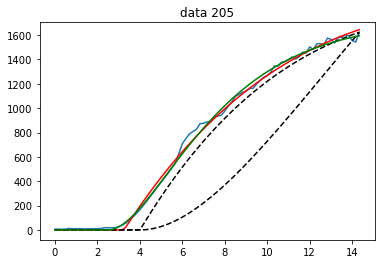

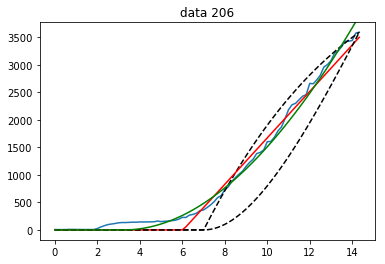

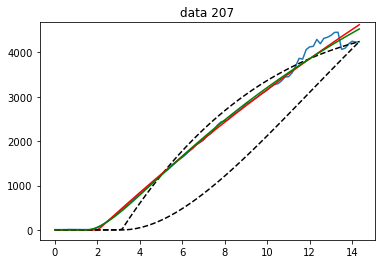

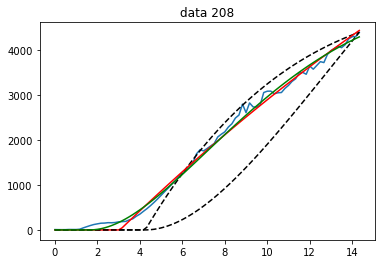

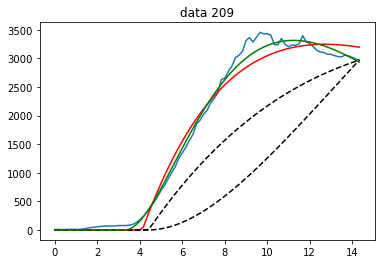

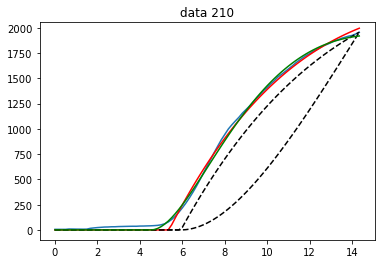

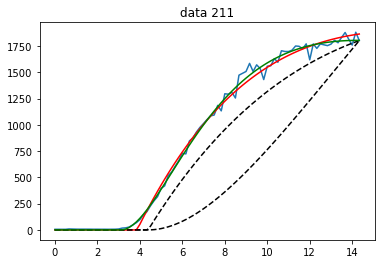

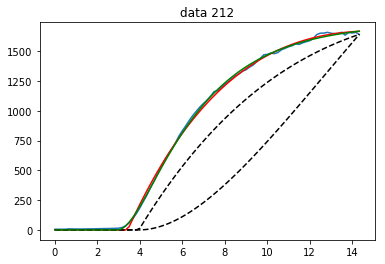

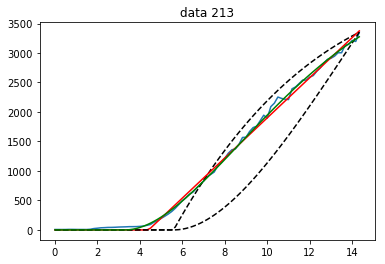

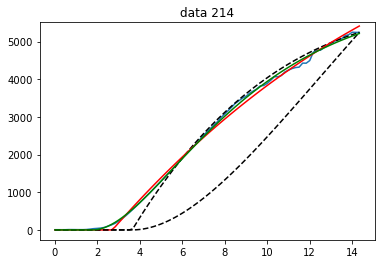

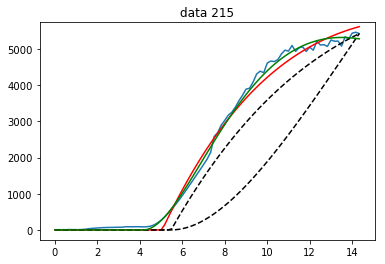

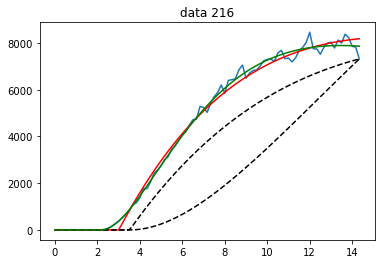

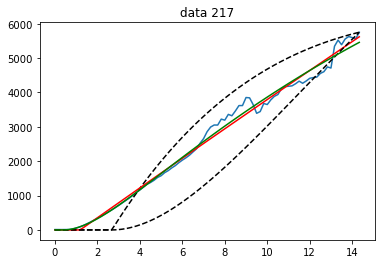

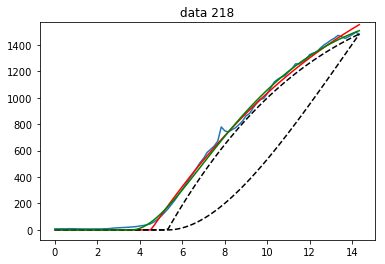

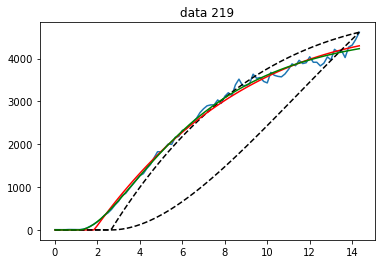

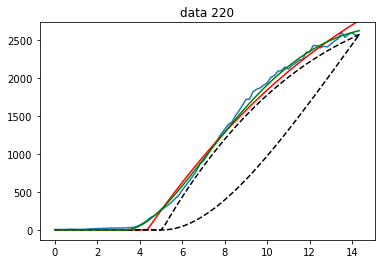

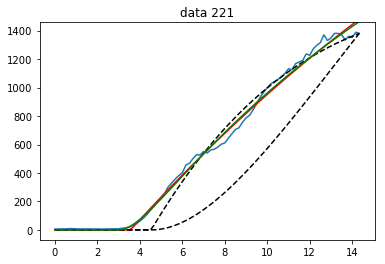

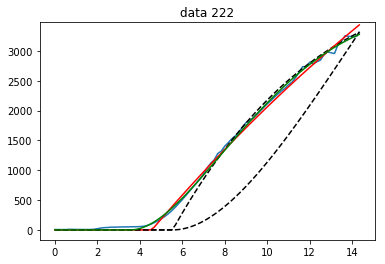

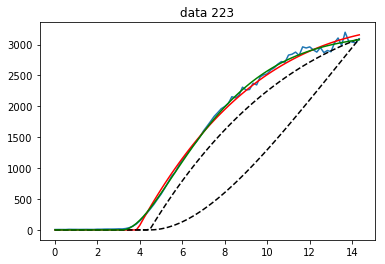

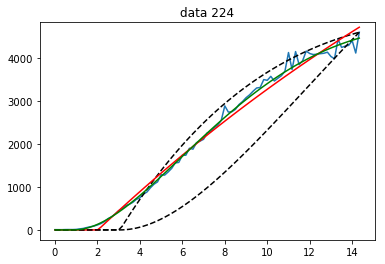

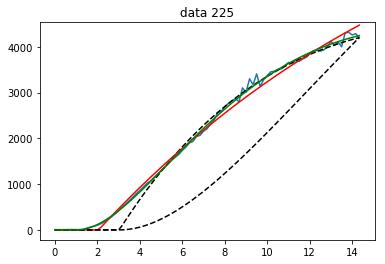

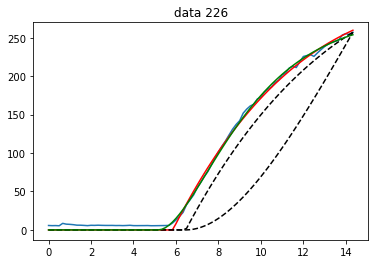

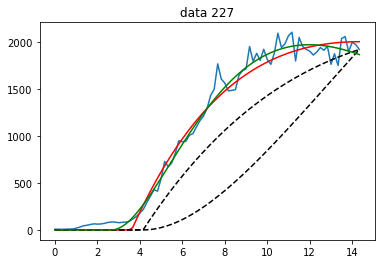

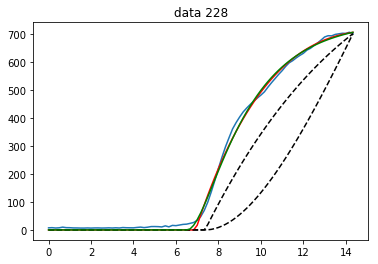

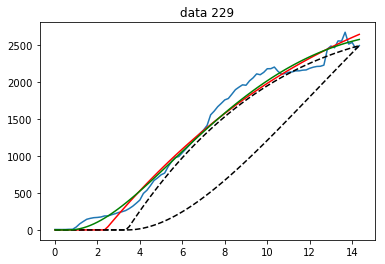

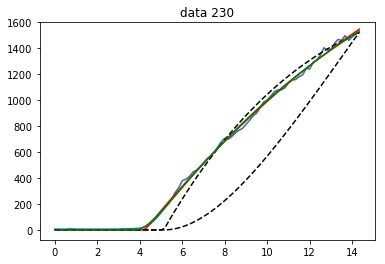

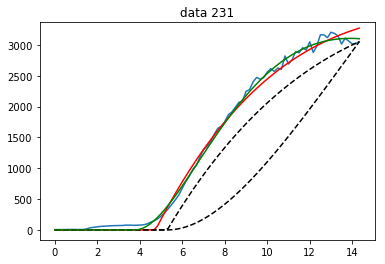

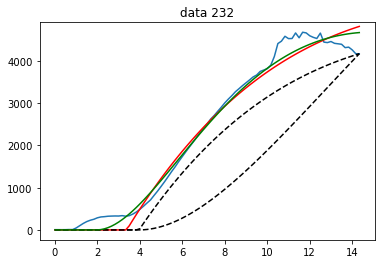

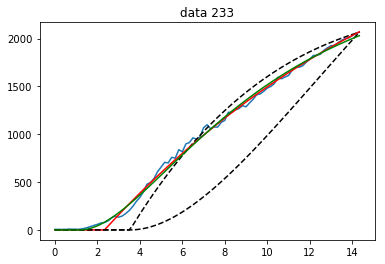

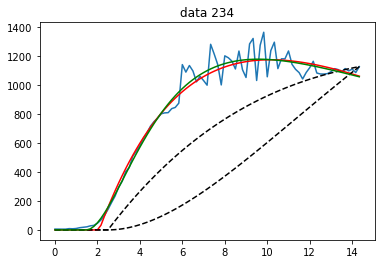

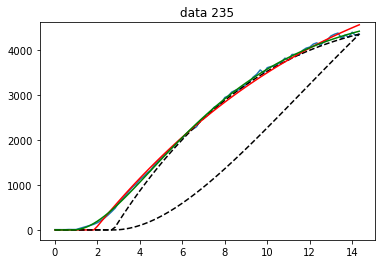

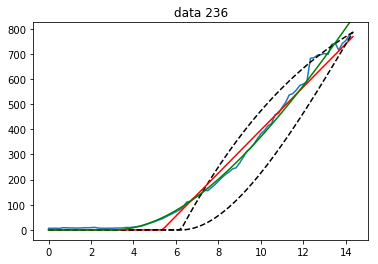

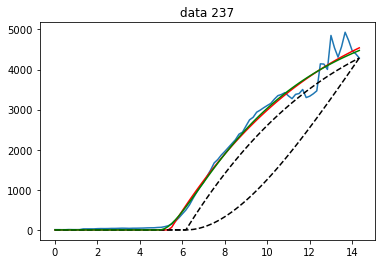

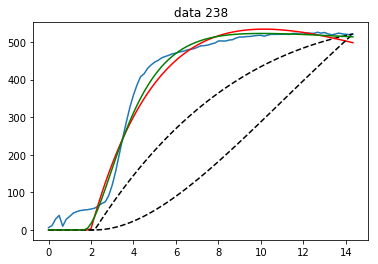

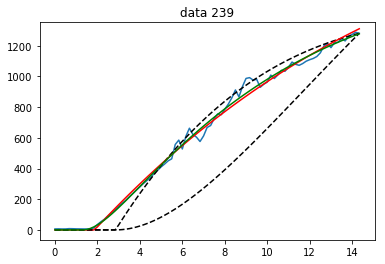

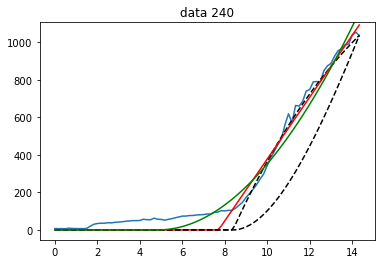

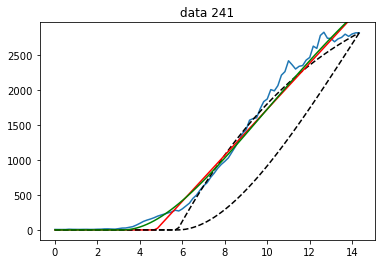

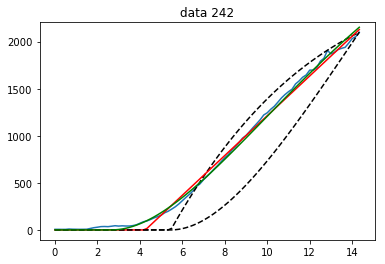

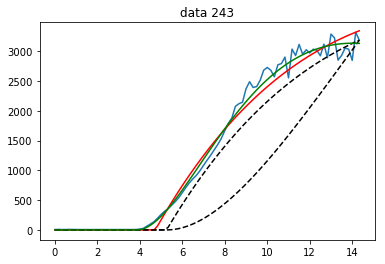

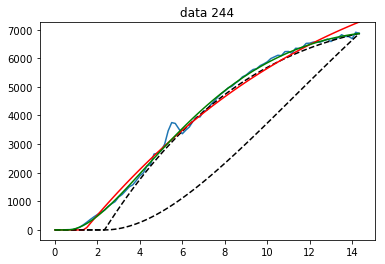

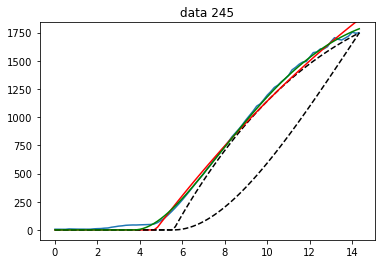

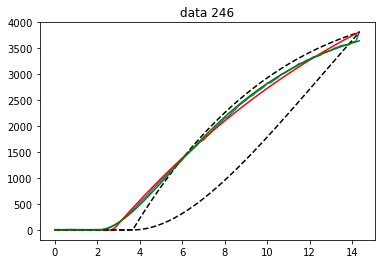

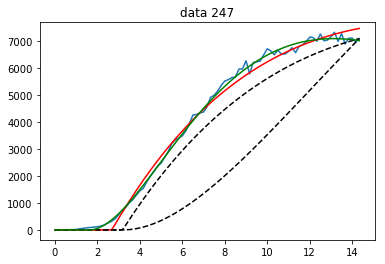

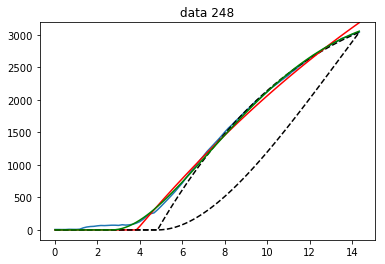

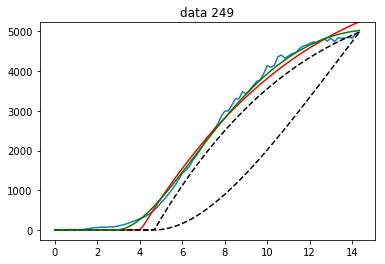

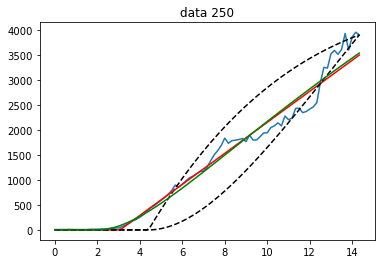

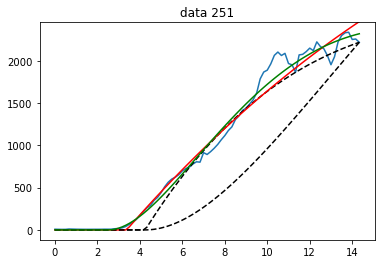

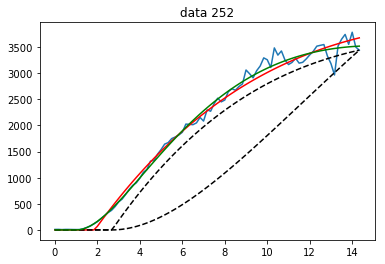

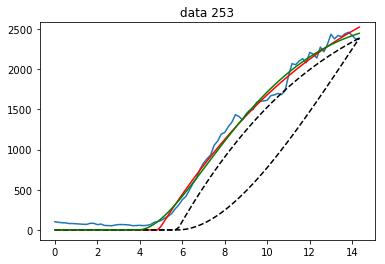

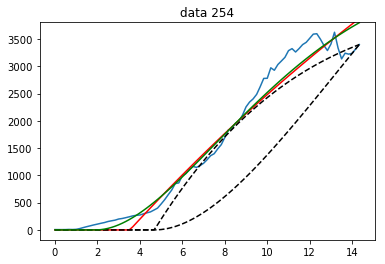

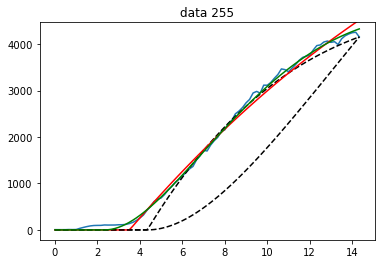

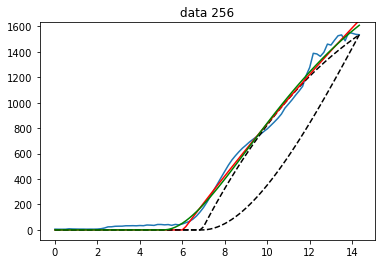

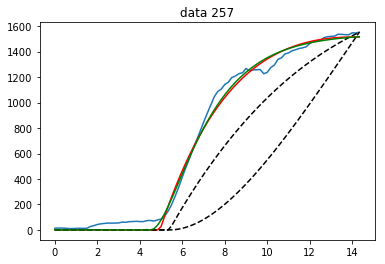

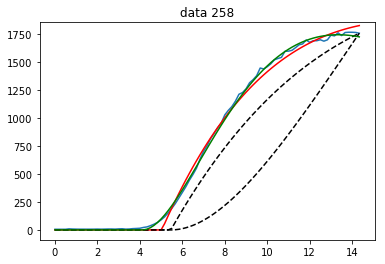

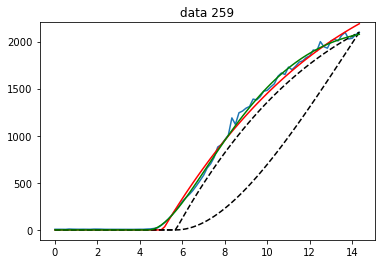

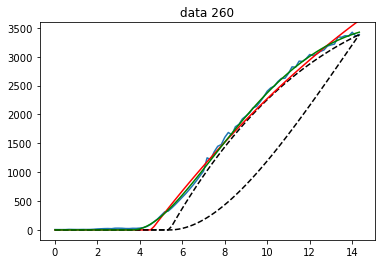

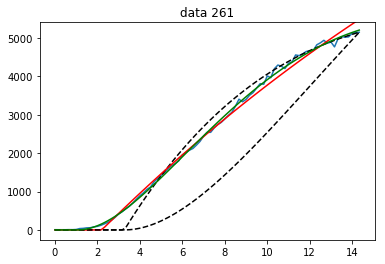

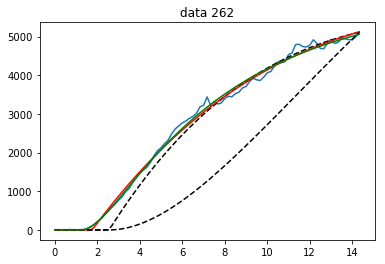

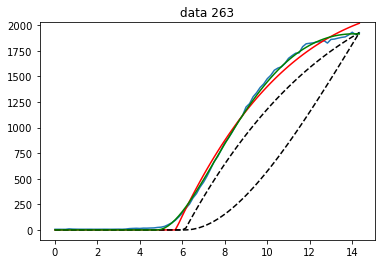

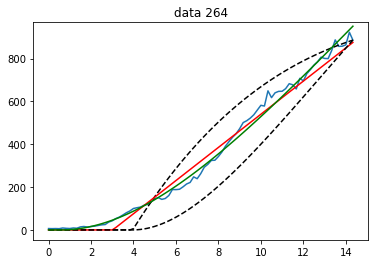

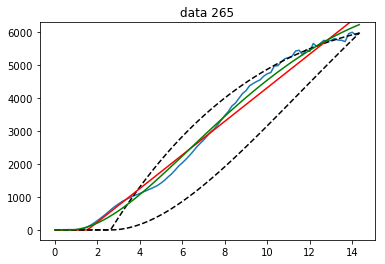

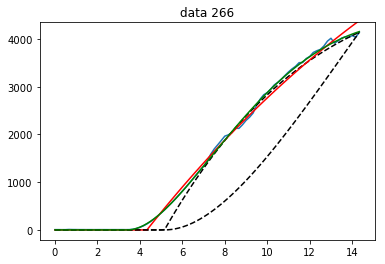

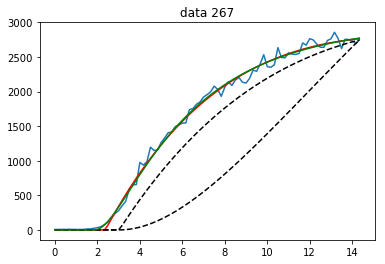

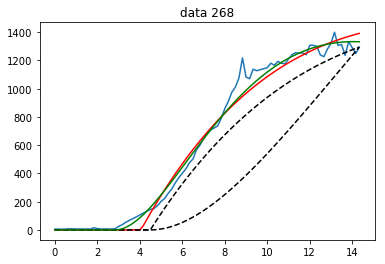

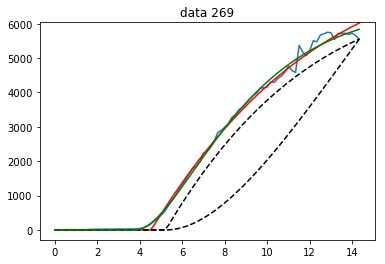

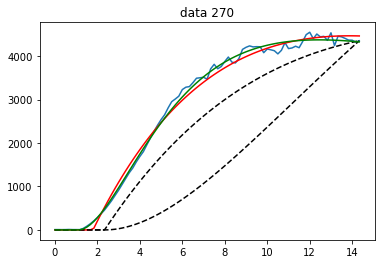

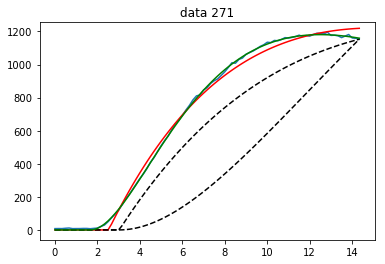

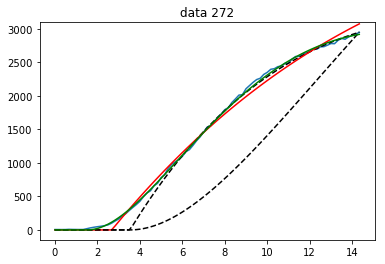

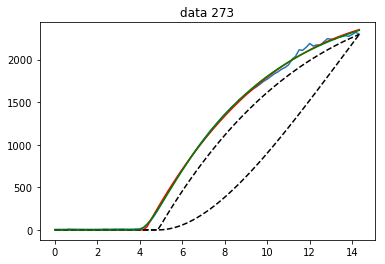

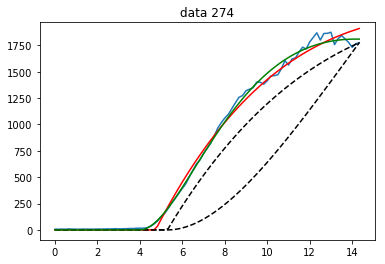

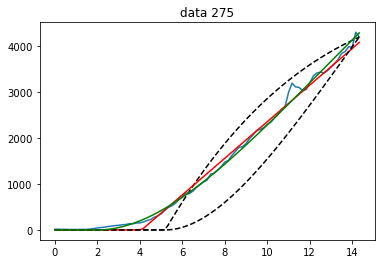

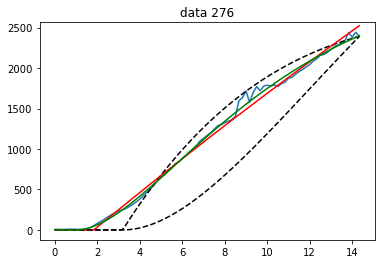

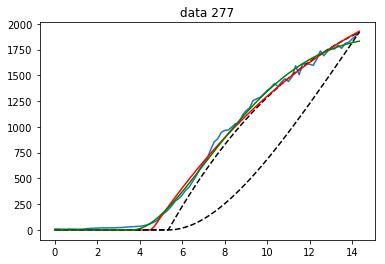

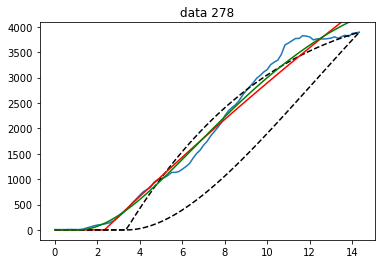

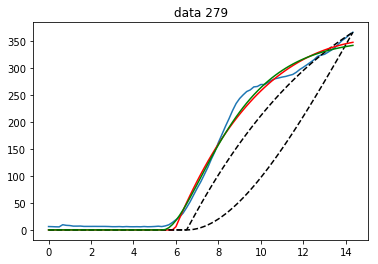

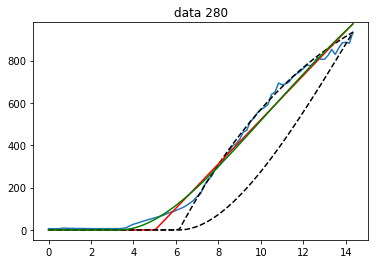

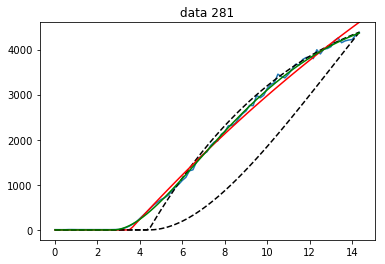

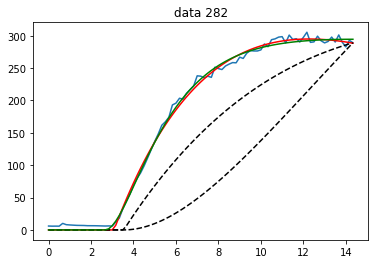

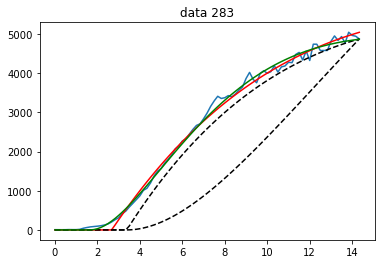

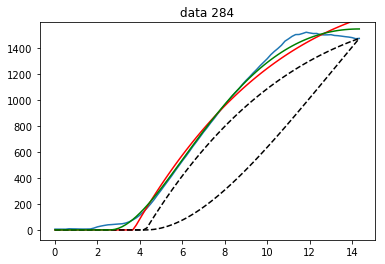

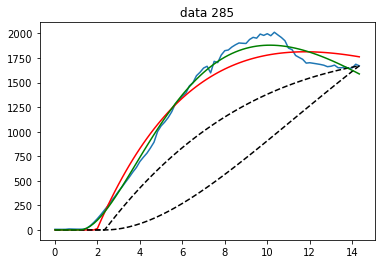

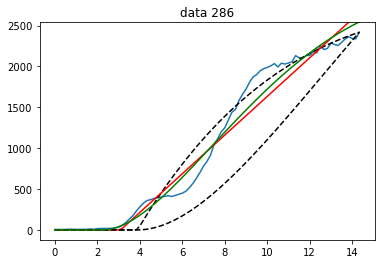

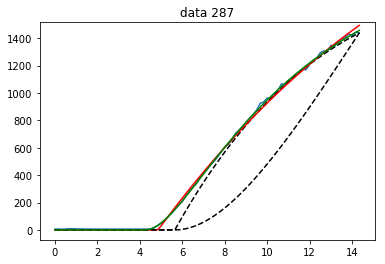

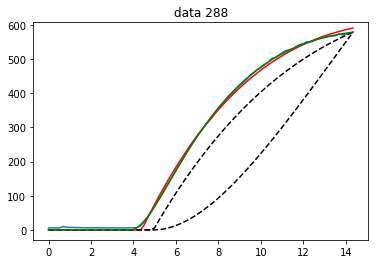

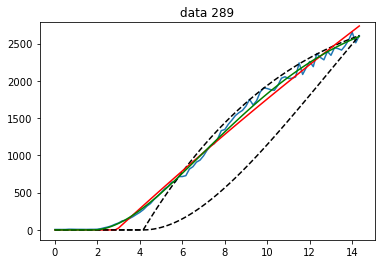

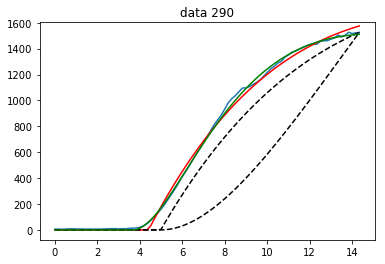

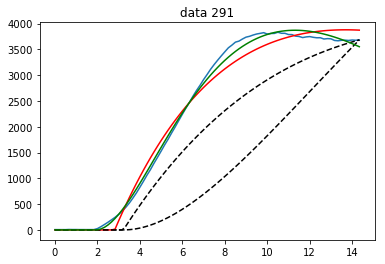

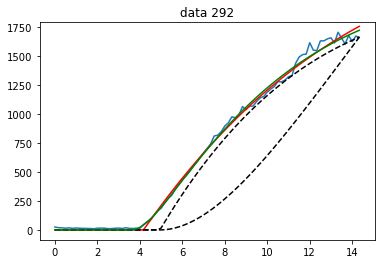

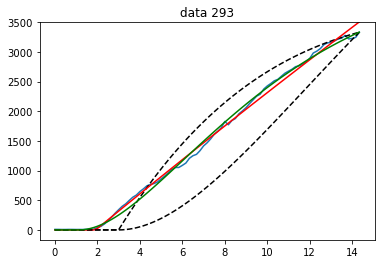

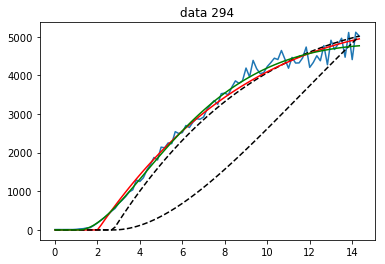

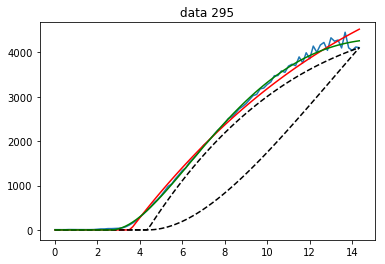

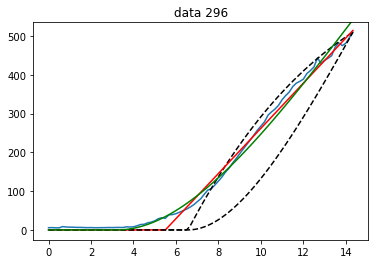

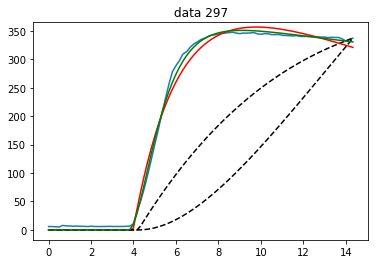

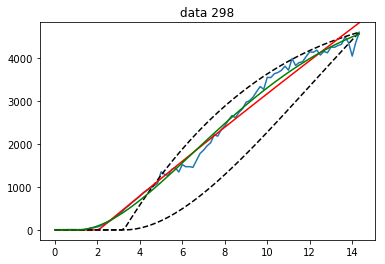

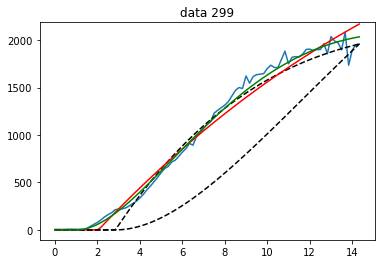

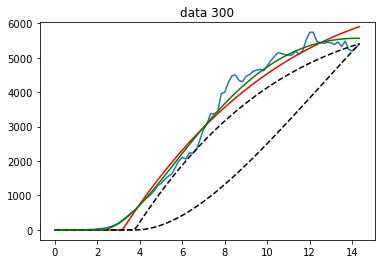

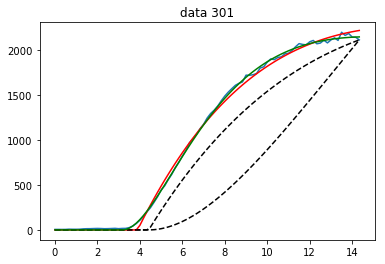

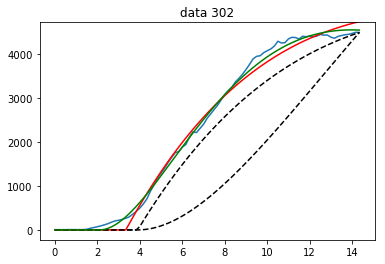

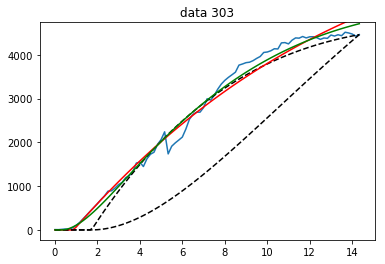

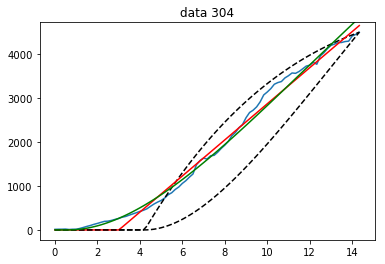

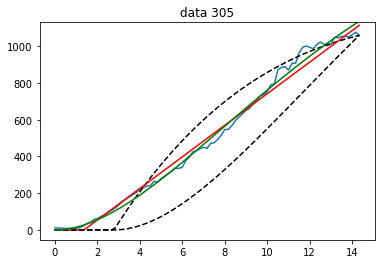

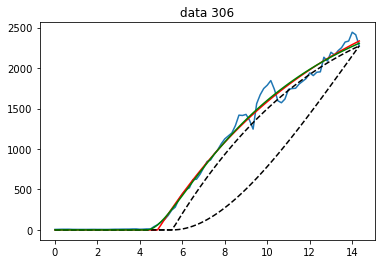

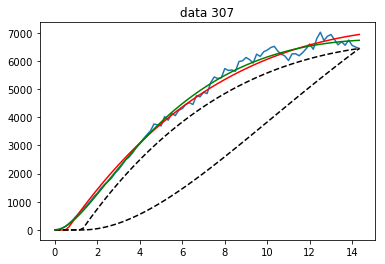

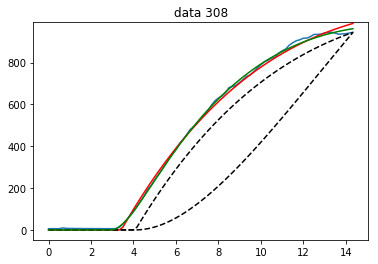

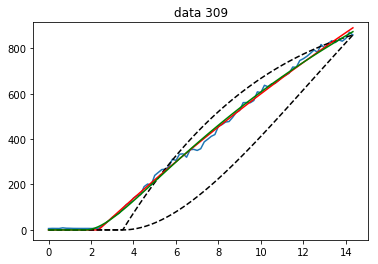

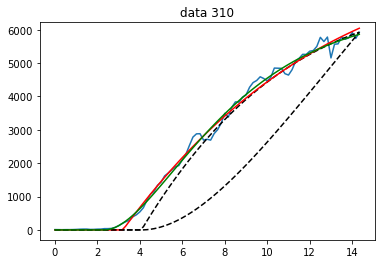

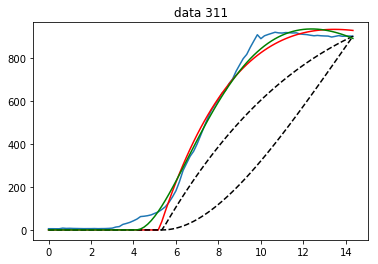

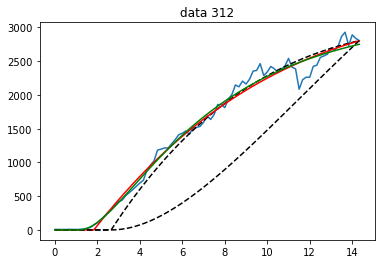

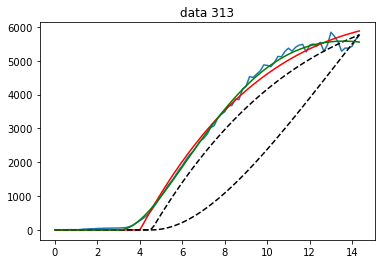

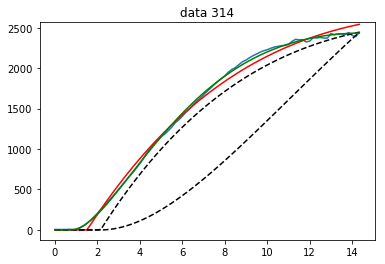

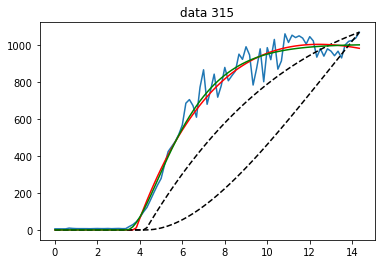

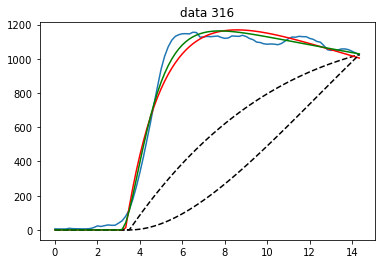

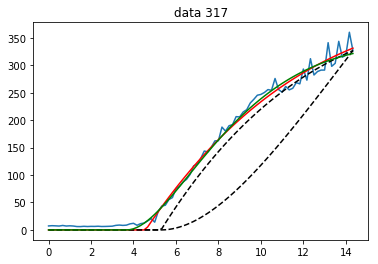

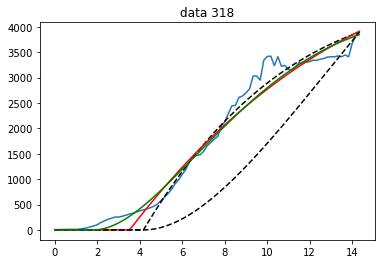

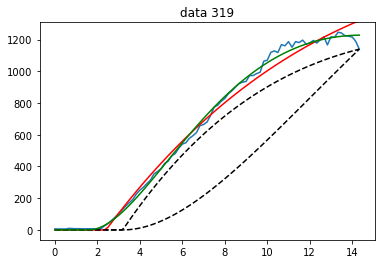

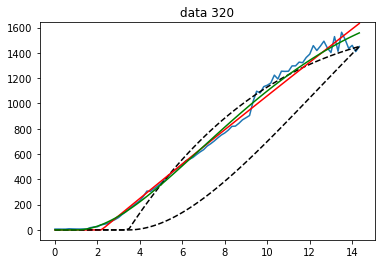

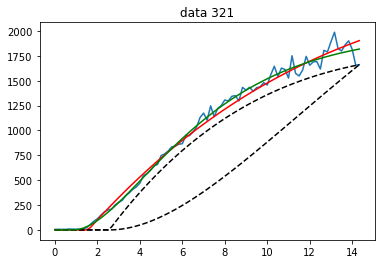

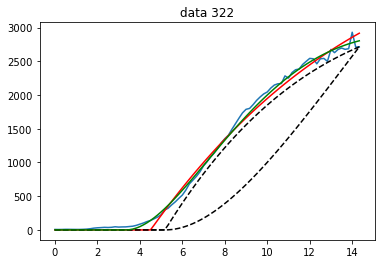

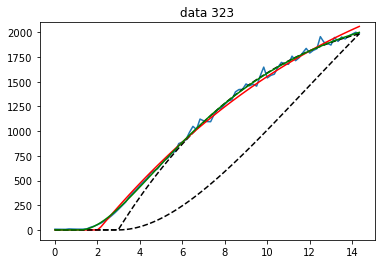

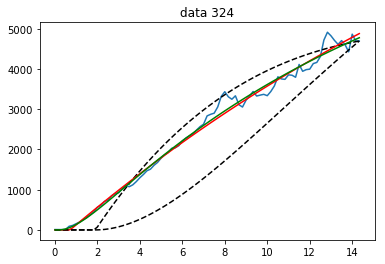

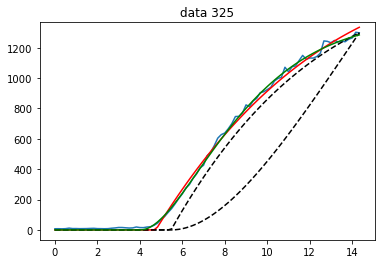

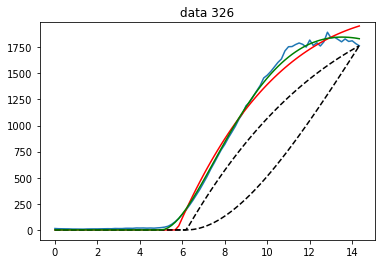

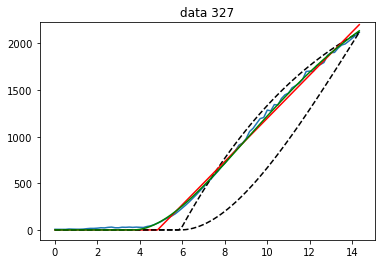

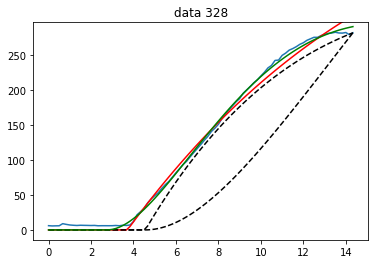

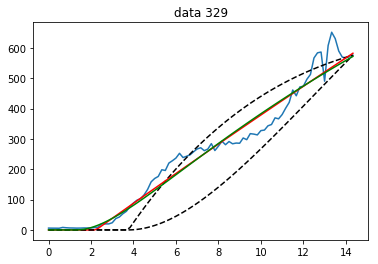

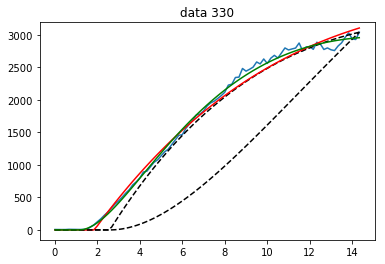

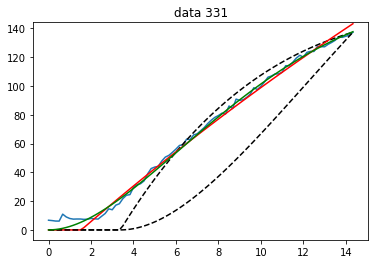

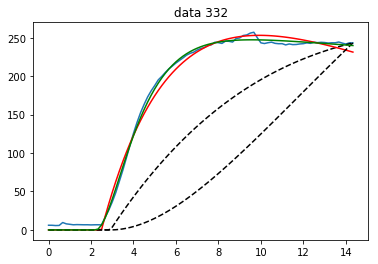

In [7]:
# two stage model
t0_list=[]
ktl_list=[]
delta_list=[]
beta_list=[]
t0_std_list=[]
ktl_std_list=[]
delta_std_list=[]
beta_std_list=[]
red_chi2_list=[]

# three stage model
t0_list3=[]
ktl_list3=[]
km_list3=[]
delta_list3=[]
beta_list3=[]
t0_std_list3=[]
ktl_std_list3=[]
km_std_list3=[]
delta_std_list3=[]
beta_std_list3=[]
red_chi2_list3=[]

for data,t0guess,i in zip(egfp_lipo,t0cluster_list,range(t0cluster_list.size)):
    sigma = np.sqrt(data)
    time = np.arange(0,data.size)*10/60
    # lets estimate the parameters
    # to estimate t0 we take I_max-I_min and estimate t for which I=I_min+0.1(I_max-Imin)
    # this can be done by interpolation.  The advantage is that the guess for t0 is greater
    # than the actual value - fits seems to converge better
    delta_I=data.max()-data.min()
    t0guess = interp1d(data,time)(data.min()+0.1*delta_I)
    delta_t=time[-1]-t0guess
    
    two=twostage(np.array([delta_t]),0,1,0.07,0.05)
    ktl2=data[-1]/two[0]
    
    three=threestage(np.array([delta_t]),0,1,0.03,0.07,0.05)
    ktl3=data[-1]/three[0]
    
    result2 = twostage_model.fit(data, t=time, t0=t0guess, ktl=ktl2, delta=0.07, beta=0.05, weights=1/sigma)
    result3 = threestage_model.fit(data, t=time, t0=t0guess, ktl=ktl3, km=0.03,delta=0.07, beta=0.05, weights=1/sigma)

    plt.figure()
    plt.title("data "+str(i))
    plt.plot(time,data)
    plt.plot(time,result2.init_fit, 'k--')
    plt.plot(time, result2.best_fit, 'r-')
    plt.plot(time,result3.init_fit, 'k--')
    plt.plot(time, result3.best_fit, 'g-')
    plt.ylim((-0.05*data.max(),data.max()*1.05))
    
    if result2:
        t0_list.append(np.abs(result2.values['t0']))
        ktl_list.append(np.abs(result2.values['ktl']))
        delta_list.append(np.abs(result2.values['delta']))
        beta_list.append(np.abs(result2.values['beta']))
        red_chi2_list.append(result2.redchi)

        t0_std_list.append(result2.covar[0][0])
        ktl_std_list.append(result2.covar[1][1])
        delta_std_list.append(result2.covar[2][2])
        beta_std_list.append(result2.covar[3][3])
    
    if result3:
        t0_list3.append(np.abs(result3.values['t0']))
        ktl_list3.append(np.abs(result3.values['ktl']))
        km_list3.append(np.abs(result3.values['km']))
        delta_list3.append(np.abs(result3.values['delta']))
        beta_list3.append(np.abs(result3.values['beta']))
        red_chi2_list3.append(result3.redchi)

        t0_std_list3.append(result3.covar[0][0])
        ktl_std_list3.append(result3.covar[1][1])
        km_std_list3.append(result3.covar[2][2])
        delta_std_list3.append(result3.covar[3][3])
        beta_std_list3.append(result3.covar[4][4])
    
t0_list=np.array(t0_list)
ktl_list=np.array(ktl_list)
delta_list=np.array(delta_list)
beta_list=np.array(beta_list)
t0_std_list=np.array(t0_std_list)
ktl_std_list=np.array(ktl_std_list)
delta_std_list=np.array(delta_std_list)
beta_std_list=np.array(beta_std_list)

t0_list3=np.array(t0_list3)
ktl_list3=np.array(ktl_list3)
km_list3=np.array(km_list3)
delta_list3=np.array(delta_list3)
beta_list3=np.array(beta_list3)
t0_std_list3=np.array(t0_std_list3)
ktl_std_list3=np.array(ktl_std_list3)
km_std_list3=np.array(km_std_list3)
delta_std_list3=np.array(delta_std_list3)
beta_std_list3=np.array(beta_std_list3)

red_chi2_list=np.array(red_chi2_list)
red_chi2_list3=np.array(red_chi2_list3)


16.814544815 9.6974407891
16.8001623469 10.7543130913
[ 55.51219123  46.94556398  22.07799347  11.17675443   6.00371886
   2.16194418]
[ 36.70558912  30.08173508  11.96178922   5.82584721   3.10722801
   1.42525889]


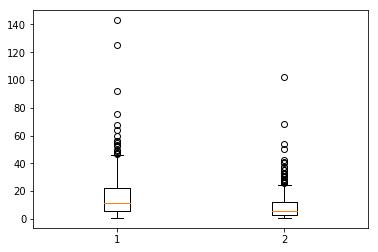

In [8]:
plt.boxplot([red_chi2_list,red_chi2_list3])
print(red_chi2_list.mean(),red_chi2_list3.mean())
print(red_chi2_list.std(),red_chi2_list3.std())
print(np.percentile(red_chi2_list,[97.5,95,75,50,25,2.5]))
print(np.percentile(red_chi2_list3,[97.5,95,75,50,25,2.5]))

In [9]:
print(np.argmax(red_chi2_list),red_chi2_list.max())
print(np.argmax(red_chi2_list3),red_chi2_list3.max())

163 142.971989437
163 102.267671152


In [25]:
# cleaning up the data by setting a threshold for redchi2
threshold2 = 150
threshold3 = 150
ktl_list_clean=ktl_list[red_chi2_list<threshold2]
delta_list_clean=delta_list[red_chi2_list<threshold2]
beta_list_clean=beta_list[red_chi2_list<threshold2]
t0_list_clean=t0_list[red_chi2_list<threshold2]
ktl_std_list_clean=ktl_std_list[red_chi2_list<threshold2]
delta_std_list_clean=delta_std_list[red_chi2_list<threshold2]
beta_std_list_clean=beta_std_list[red_chi2_list<threshold2]
t0_std_list_clean=t0_std_list[red_chi2_list<threshold2]

ktl_list3_clean=ktl_list3[red_chi2_list3<threshold3]
km_list3_clean=km_list3[red_chi2_list3<threshold3]
delta_list3_clean=delta_list3[red_chi2_list3<threshold3]
beta_list3_clean=beta_list3[red_chi2_list3<threshold3]
t0_list3_clean=t0_list3[red_chi2_list3<threshold3]
km_std_list3_clean=km_std_list3[red_chi2_list3<threshold3]
ktl_std_list3_clean=ktl_std_list3[red_chi2_list3<threshold3]
delta_std_list3_clean=delta_std_list3[red_chi2_list3<threshold3]
beta_std_list3_clean=beta_std_list3[red_chi2_list3<threshold3]
t0_std_list3_clean=t0_std_list3[red_chi2_list3<threshold3]


In [11]:
print(ktl_list.size,ktl_list_clean.size)
print(ktl_list3.size,ktl_list3_clean.size)

333 331
333 332


530.96588464 13153.1360663


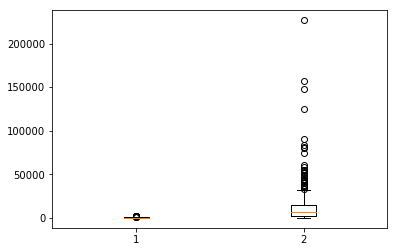

In [12]:
plt.boxplot([ktl_list_clean,ktl_list3_clean])
print(ktl_list_clean.mean(),ktl_list3_clean.mean())

(array([ 279.,   34.,   10.,    5.,    0.,    1.,    2.,    0.,    0.,    1.]),
 array([  1.26684952e+02,   2.27876869e+04,   4.54486888e+04,
          6.81096908e+04,   9.07706927e+04,   1.13431695e+05,
          1.36092697e+05,   1.58753699e+05,   1.81414700e+05,
          2.04075702e+05,   2.26736704e+05]),
 <a list of 10 Patch objects>)

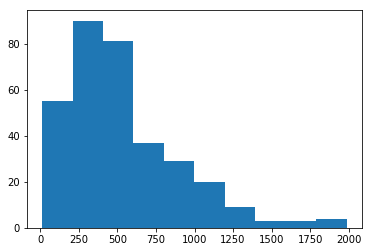

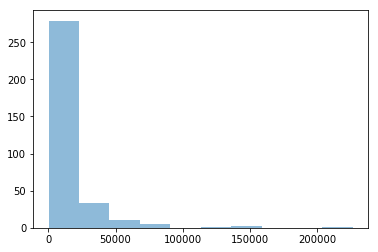

In [13]:
plt.figure()
plt.hist(ktl_list_clean)
plt.figure()
plt.hist(ktl_list3_clean,alpha=0.5)

(array([ 233.,   42.,   26.,   17.,    5.,    3.,    1.,    3.,    0.,    2.]),
 array([ 0.003058  ,  0.12839708,  0.25373617,  0.37907525,  0.50441433,
         0.62975341,  0.7550925 ,  0.88043158,  1.00577066,  1.13110975,
         1.25644883]),
 <a list of 10 Patch objects>)

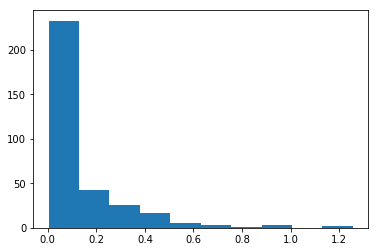

In [14]:
plt.figure()
plt.hist(km_list3_clean)

{'boxes': [<matplotlib.lines.Line2D at 0x131b707b8>,
 'caps': [<matplotlib.lines.Line2D at 0x131b77b70>,
 'fliers': [<matplotlib.lines.Line2D at 0x131b83ac8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x131b7dbe0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x131b70a20>,
  <matplotlib.lines.Line2D at 0x131b89c88>]}

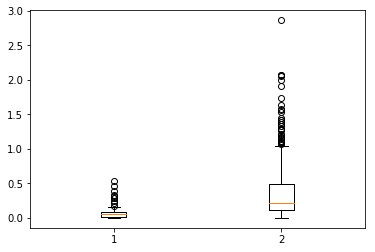

In [15]:
plt.boxplot([delta_list_clean,delta_list3_clean])

0.0586504083229 0.393233571674


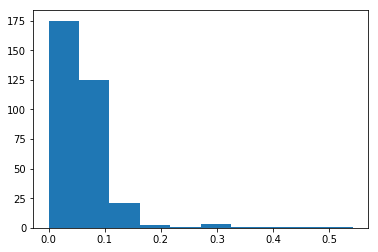

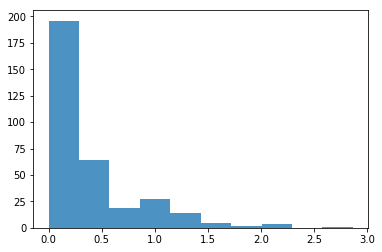

In [16]:
plt.figure()
plt.hist(delta_list_clean)
plt.figure()
plt.hist(delta_list3_clean,alpha=0.8)
print(delta_list_clean.mean(),delta_list3_clean.mean())

{'boxes': [<matplotlib.lines.Line2D at 0x131dc9d68>,
 'caps': [<matplotlib.lines.Line2D at 0x131e347f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x131e3af98>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x131e3a1d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x131dc9fd0>,
  <matplotlib.lines.Line2D at 0x131e47908>]}

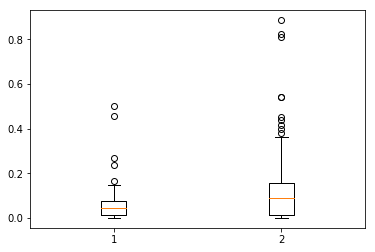

In [17]:
plt.boxplot([beta_list_clean,beta_list3_clean])

(array([ 167.,   99.,   38.,   17.,    5.,    1.,    2.,    0.,    0.,    3.]),
 array([  4.01807833e-09,   8.84751808e-02,   1.76950358e-01,
          2.65425534e-01,   3.53900711e-01,   4.42375888e-01,
          5.30851065e-01,   6.19326242e-01,   7.07801419e-01,
          7.96276595e-01,   8.84751772e-01]),
 <a list of 10 Patch objects>)

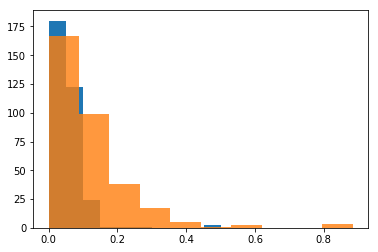

In [18]:
plt.hist(beta_list_clean)
plt.hist(beta_list3_clean,alpha=0.8)

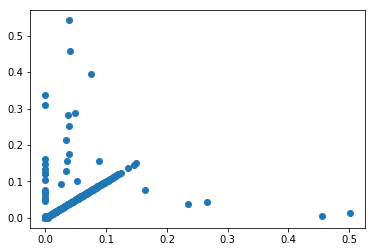

In [19]:
plt.plot(beta_list_clean,delta_list_clean,"o")

{'boxes': [<matplotlib.lines.Line2D at 0x1322eb780>],
 'caps': [<matplotlib.lines.Line2D at 0x1322f5b38>,
 'fliers': [<matplotlib.lines.Line2D at 0x1322ffa90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1322faba8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1322eb9e8>,
  <matplotlib.lines.Line2D at 0x1322f59b0>]}

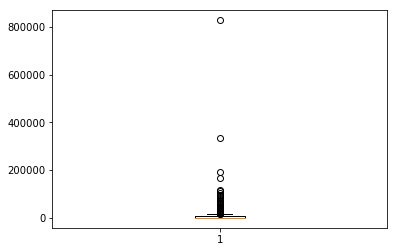

In [20]:
error_delta = delta_std_list_clean/delta_list_clean
plt.boxplot(error_delta)

{'boxes': [<matplotlib.lines.Line2D at 0x131cef898>,
 'caps': [<matplotlib.lines.Line2D at 0x131acb0b8>,
 'fliers': [<matplotlib.lines.Line2D at 0x131ca2cc0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x131ca2a58>,
 'whiskers': [<matplotlib.lines.Line2D at 0x131cef9b0>,
  <matplotlib.lines.Line2D at 0x131c868d0>]}

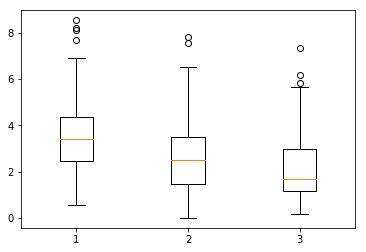

In [21]:
plt.boxplot([t0_list_clean,t0_list3_clean,t0cluster_list])

3.48095110026
2.52705367214
2.08858858859


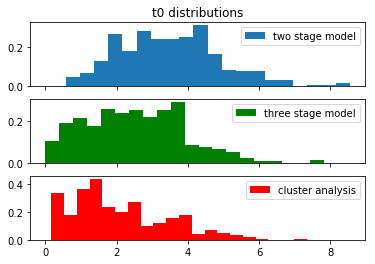

In [22]:
plt.figure()
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(3, sharex=True)
axarr[0].hist(t0_list_clean, bins=20,normed=True,label='two stage model')
axarr[0].set_title('t0 distributions')
axarr[0].legend()
axarr[1].hist(t0_list3_clean,bins=20,color='g',normed=True,label='three stage model')
axarr[1].legend()
axarr[2].hist(t0cluster_list,bins=20,color='r',normed=True,label='cluster analysis')
axarr[2].legend()
print(t0_list_clean.mean())
print(t0_list3_clean.mean())
print(t0cluster_list.mean())

In [28]:
# save data
np.save("lipo2_t0_two",t0_list_clean)
np.save("lipo2_t0_three",t0_list3_clean)
np.save("lipo2_t0_cluster",t0cluster_list)

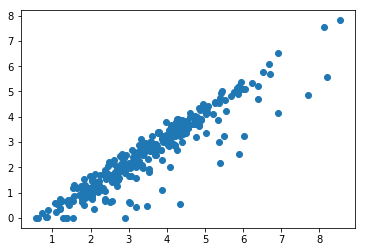

In [27]:
plt.plot(t0_list_clean,t0_list3_clean,"o")